In [4]:
import torch
import torch.nn as nn

In [5]:
import csv
import os
import time
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from keras import layers
from numpy.random import seed
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from keras.layers import Input
from keras.models import Model
from keras.regularizers import l1, l2, l1_l2
from keras.wrappers.scikit_learn import KerasRegressor
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from plotly.graph_objects import *
from plotly.offline import init_notebook_mode
import joblib
import xgboost as xgb
import pandas as pd
import datetime
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
import torch
from sklearn.preprocessing import minmax_scale
# import lightgbm as lgb
seed(1)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import json

In [7]:
#energy_data = pd.read_csv("./Energy/data/energy.csv")

In [8]:
fcst_data_hk = pd.read_csv("./data/hk1_fcst_data_wind.csv")

In [9]:
fcst_data_ss = pd.read_csv("./data/ss_fcst_data_wind.csv")

In [10]:
fcst_data_hk

,tgt_Y,tgt_M,tgt_D,tgt_tz,temperature,humidity,windspeed,winddirection,6hrain,6hsnow,rainprobability,raintype,seawave,skystatus,hk1_numberofturbineinuse,hk1,hk2_numberofturbineinuse,hk2
0,2014,1,1,2,12.1,43.0,8.1,285.0,0.0,0.0,0.0,0.0,1.5,1.0,2.000000,2481.300000,4.000000,8287.740000
1,2014,1,1,3,10.6,50.0,8.0,285.0,0.0,0.0,0.0,0.0,1.0,1.0,2.166667,2376.850000,4.000000,7438.154667
2,2014,1,1,4,10.2,50.0,8.2,278.0,0.0,0.0,0.0,0.0,1.0,1.0,2.944444,1693.833333,4.000000,3426.450000
3,2014,1,1,5,8.4,50.0,6.9,281.0,0.0,0.0,0.0,0.0,1.0,1.0,3.000000,1550.994444,4.000000,2950.589000
4,2014,1,1,6,8.0,50.0,6.4,298.0,0.0,0.0,0.0,0.0,1.0,1.0,3.000000,1214.227778,4.000000,2195.714667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11682,2017,12,31,4,6.0,50.0,6.9,330.0,0.0,0.0,30.0,NaN,1.0,3.0,3.000000,3070.516667,3.000000,4801.813667
11683,2017,12,31,5,5.0,55.0,6.4,334.0,0.0,0.0,30.0,NaN,1.0,3.0,3.000000,3964.450000,3.000000,6480.021000
11684,2017,12,31,6,6.0,50.0,7.3,347.0,0.0,0.0,20.0,NaN,1.0,3.0,3.000000,3679.100000,2.444444,4828.718667
11685,2017,12,31,7,5.0,55.0,7.3,358.0,0.0,0.0,20.0,NaN,1.0,3.0,3.000000,2830.772222,2.000000,2839.131333


In [11]:
fcst_data_hk1=fcst_data_hk.drop(['hk2_numberofturbineinuse','hk2'],axis = 1)

In [12]:
fcst_data_hk2=fcst_data_hk.drop(['hk1_numberofturbineinuse','hk1'],axis = 1)

In [13]:
fcst_data_hk1.tail()

,tgt_Y,tgt_M,tgt_D,tgt_tz,temperature,humidity,windspeed,winddirection,6hrain,6hsnow,rainprobability,raintype,seawave,skystatus,hk1_numberofturbineinuse,hk1
11682,2017,12,31,4,6.0,50.0,6.9,330.0,0.0,0.0,30.0,NaN,1.0,3.0,3.0,3070.516667
11683,2017,12,31,5,5.0,55.0,6.4,334.0,0.0,0.0,30.0,NaN,1.0,3.0,3.0,3964.450000
11684,2017,12,31,6,6.0,50.0,7.3,347.0,0.0,0.0,20.0,NaN,1.0,3.0,3.0,3679.100000
11685,2017,12,31,7,5.0,55.0,7.3,358.0,0.0,0.0,20.0,NaN,1.0,3.0,3.0,2830.772222
11686,2018,1,1,0,5.0,55.0,6.8,3.0,0.0,0.0,20.0,NaN,1.0,3.0,3.0,2648.337500


In [14]:
fcst_data_hk2.tail()

,tgt_Y,tgt_M,tgt_D,tgt_tz,temperature,humidity,windspeed,winddirection,6hrain,6hsnow,rainprobability,raintype,seawave,skystatus,hk2_numberofturbineinuse,hk2
11682,2017,12,31,4,6.0,50.0,6.9,330.0,0.0,0.0,30.0,NaN,1.0,3.0,3.000000,4801.813667
11683,2017,12,31,5,5.0,55.0,6.4,334.0,0.0,0.0,30.0,NaN,1.0,3.0,3.000000,6480.021000
11684,2017,12,31,6,6.0,50.0,7.3,347.0,0.0,0.0,20.0,NaN,1.0,3.0,2.444444,4828.718667
11685,2017,12,31,7,5.0,55.0,7.3,358.0,0.0,0.0,20.0,NaN,1.0,3.0,2.000000,2839.131333
11686,2018,1,1,0,5.0,55.0,6.8,3.0,0.0,0.0,20.0,NaN,1.0,3.0,2.000000,2733.496500


In [15]:
fcst_data_ss.tail()

,tgt_Y,tgt_M,tgt_D,tgt_tz,temperature,humidity,windspeed,winddirection,6hrain,6hsnow,rainprobability,raintype,seawave,skystatus,ss_numberofturbineinuse,ss
11682,2017,12,31,4,6.0,65.0,6.4,337.0,0.0,0.0,20.0,NaN,0.5,3.0,10.0,8257.814000
11683,2017,12,31,5,6.0,65.0,5.7,341.0,0.0,0.0,20.0,NaN,0.5,3.0,10.0,11685.699330
11684,2017,12,31,6,6.0,60.0,5.9,348.0,0.0,0.0,20.0,NaN,0.5,3.0,10.0,9262.301667
11685,2017,12,31,7,5.0,60.0,6.3,348.0,0.0,0.0,20.0,NaN,0.5,3.0,10.0,6464.907333
11686,2018,1,1,0,5.0,55.0,5.7,353.0,0.0,0.0,20.0,NaN,0.5,3.0,10.0,5493.858000


In [16]:
columns = fcst_data_hk1.columns

In [17]:
columns

Index(['tgt_Y', 'tgt_M', 'tgt_D', 'tgt_tz', 'temperature', 'humidity',
       'windspeed', 'winddirection', '6hrain', '6hsnow', 'rainprobability',
       'raintype', 'seawave', 'skystatus', 'hk1_numberofturbineinuse', 'hk1'],
      dtype='object')

In [18]:
fcst_data_hk2.tail()

,tgt_Y,tgt_M,tgt_D,tgt_tz,temperature,humidity,windspeed,winddirection,6hrain,6hsnow,rainprobability,raintype,seawave,skystatus,hk2_numberofturbineinuse,hk2
11682,2017,12,31,4,6.0,50.0,6.9,330.0,0.0,0.0,30.0,NaN,1.0,3.0,3.000000,4801.813667
11683,2017,12,31,5,5.0,55.0,6.4,334.0,0.0,0.0,30.0,NaN,1.0,3.0,3.000000,6480.021000
11684,2017,12,31,6,6.0,50.0,7.3,347.0,0.0,0.0,20.0,NaN,1.0,3.0,2.444444,4828.718667
11685,2017,12,31,7,5.0,55.0,7.3,358.0,0.0,0.0,20.0,NaN,1.0,3.0,2.000000,2839.131333
11686,2018,1,1,0,5.0,55.0,6.8,3.0,0.0,0.0,20.0,NaN,1.0,3.0,2.000000,2733.496500


In [19]:
fcst_data_hk1 = fcst_data_hk1.drop(fcst_data_hk1.tail(1).index)
fcst_data_hk2 = fcst_data_hk2.drop(fcst_data_hk2.tail(1).index)
fcst_data_ss = fcst_data_ss.drop(fcst_data_ss.tail(1).index)

In [20]:
fcst_data_hk1.tail()

,tgt_Y,tgt_M,tgt_D,tgt_tz,temperature,humidity,windspeed,winddirection,6hrain,6hsnow,rainprobability,raintype,seawave,skystatus,hk1_numberofturbineinuse,hk1
11681,2017,12,31,3,6.0,50.0,7.8,333.0,0.0,0.0,20.0,NaN,1.5,3.0,3.0,3815.338889
11682,2017,12,31,4,6.0,50.0,6.9,330.0,0.0,0.0,30.0,NaN,1.0,3.0,3.0,3070.516667
11683,2017,12,31,5,5.0,55.0,6.4,334.0,0.0,0.0,30.0,NaN,1.0,3.0,3.0,3964.450000
11684,2017,12,31,6,6.0,50.0,7.3,347.0,0.0,0.0,20.0,NaN,1.0,3.0,3.0,3679.100000
11685,2017,12,31,7,5.0,55.0,7.3,358.0,0.0,0.0,20.0,NaN,1.0,3.0,3.0,2830.772222


In [21]:
fcst_data_hk2.tail()

,tgt_Y,tgt_M,tgt_D,tgt_tz,temperature,humidity,windspeed,winddirection,6hrain,6hsnow,rainprobability,raintype,seawave,skystatus,hk2_numberofturbineinuse,hk2
11681,2017,12,31,3,6.0,50.0,7.8,333.0,0.0,0.0,20.0,NaN,1.5,3.0,3.000000,6404.991333
11682,2017,12,31,4,6.0,50.0,6.9,330.0,0.0,0.0,30.0,NaN,1.0,3.0,3.000000,4801.813667
11683,2017,12,31,5,5.0,55.0,6.4,334.0,0.0,0.0,30.0,NaN,1.0,3.0,3.000000,6480.021000
11684,2017,12,31,6,6.0,50.0,7.3,347.0,0.0,0.0,20.0,NaN,1.0,3.0,2.444444,4828.718667
11685,2017,12,31,7,5.0,55.0,7.3,358.0,0.0,0.0,20.0,NaN,1.0,3.0,2.000000,2839.131333


In [22]:
fcst_data_ss.tail()

,tgt_Y,tgt_M,tgt_D,tgt_tz,temperature,humidity,windspeed,winddirection,6hrain,6hsnow,rainprobability,raintype,seawave,skystatus,ss_numberofturbineinuse,ss
11681,2017,12,31,3,7.0,60.0,6.8,333.0,0.0,0.0,20.0,NaN,0.5,3.0,10.0,8737.075000
11682,2017,12,31,4,6.0,65.0,6.4,337.0,0.0,0.0,20.0,NaN,0.5,3.0,10.0,8257.814000
11683,2017,12,31,5,6.0,65.0,5.7,341.0,0.0,0.0,20.0,NaN,0.5,3.0,10.0,11685.699330
11684,2017,12,31,6,6.0,60.0,5.9,348.0,0.0,0.0,20.0,NaN,0.5,3.0,10.0,9262.301667
11685,2017,12,31,7,5.0,60.0,6.3,348.0,0.0,0.0,20.0,NaN,0.5,3.0,10.0,6464.907333


In [23]:
#feature 추가
def add_feature(dataset):
    dataset["n_winddirection"] = np.abs(dataset["windspeed"])
    dataset["n_winddirection"] = -np.sin(dataset["n_winddirection"])

    dataset["s_winddirection"] = np.abs(dataset["windspeed"])
    dataset["s_winddirection"] = -np.cos(dataset["s_winddirection"])

    dataset["windrelationship"] = dataset["windspeed"] ** 3

    dataset["tgt_season"] = (dataset.tgt_M%12 + 3)//3
    
    return dataset
    

In [24]:
fcst_data_hk1 = add_feature(fcst_data_hk1)

In [25]:
fcst_data_hk2 = add_feature(fcst_data_hk2)

In [26]:
fcst_data_ss = add_feature(fcst_data_ss)

In [27]:
fcst_data_hk1

,tgt_Y,tgt_M,tgt_D,tgt_tz,temperature,humidity,windspeed,winddirection,6hrain,6hsnow,rainprobability,raintype,seawave,skystatus,hk1_numberofturbineinuse,hk1,n_winddirection,s_winddirection,windrelationship,tgt_season
0,2014,1,1,2,12.1,43.0,8.1,285.0,0.0,0.0,0.0,0.0,1.5,1.0,2.000000,2481.300000,-0.969890,0.243544,531.441,1
1,2014,1,1,3,10.6,50.0,8.0,285.0,0.0,0.0,0.0,0.0,1.0,1.0,2.166667,2376.850000,-0.989358,0.145500,512.000,1
2,2014,1,1,4,10.2,50.0,8.2,278.0,0.0,0.0,0.0,0.0,1.0,1.0,2.944444,1693.833333,-0.940731,0.339155,551.368,1
3,2014,1,1,5,8.4,50.0,6.9,281.0,0.0,0.0,0.0,0.0,1.0,1.0,3.000000,1550.994444,-0.578440,-0.815725,328.509,1
4,2014,1,1,6,8.0,50.0,6.4,298.0,0.0,0.0,0.0,0.0,1.0,1.0,3.000000,1214.227778,-0.116549,-0.993185,262.144,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,2017,12,31,3,6.0,50.0,7.8,333.0,0.0,0.0,20.0,NaN,1.5,3.0,3.000000,3815.338889,-0.998543,-0.053955,474.552,1
11682,2017,12,31,4,6.0,50.0,6.9,330.0,0.0,0.0,30.0,NaN,1.0,3.0,3.000000,3070.516667,-0.578440,-0.815725,328.509,1
11683,2017,12,31,5,5.0,55.0,6.4,334.0,0.0,0.0,30.0,NaN,1.0,3.0,3.000000,3964.450000,-0.116549,-0.993185,262.144,1
11684,2017,12,31,6,6.0,50.0,7.3,347.0,0.0,0.0,20.0,NaN,1.0,3.0,3.000000,3679.100000,-0.850437,-0.526078,389.017,1


In [28]:
fcst_data_hk2

,tgt_Y,tgt_M,tgt_D,tgt_tz,temperature,humidity,windspeed,winddirection,6hrain,6hsnow,rainprobability,raintype,seawave,skystatus,hk2_numberofturbineinuse,hk2,n_winddirection,s_winddirection,windrelationship,tgt_season
0,2014,1,1,2,12.1,43.0,8.1,285.0,0.0,0.0,0.0,0.0,1.5,1.0,4.000000,8287.740000,-0.969890,0.243544,531.441,1
1,2014,1,1,3,10.6,50.0,8.0,285.0,0.0,0.0,0.0,0.0,1.0,1.0,4.000000,7438.154667,-0.989358,0.145500,512.000,1
2,2014,1,1,4,10.2,50.0,8.2,278.0,0.0,0.0,0.0,0.0,1.0,1.0,4.000000,3426.450000,-0.940731,0.339155,551.368,1
3,2014,1,1,5,8.4,50.0,6.9,281.0,0.0,0.0,0.0,0.0,1.0,1.0,4.000000,2950.589000,-0.578440,-0.815725,328.509,1
4,2014,1,1,6,8.0,50.0,6.4,298.0,0.0,0.0,0.0,0.0,1.0,1.0,4.000000,2195.714667,-0.116549,-0.993185,262.144,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,2017,12,31,3,6.0,50.0,7.8,333.0,0.0,0.0,20.0,NaN,1.5,3.0,3.000000,6404.991333,-0.998543,-0.053955,474.552,1
11682,2017,12,31,4,6.0,50.0,6.9,330.0,0.0,0.0,30.0,NaN,1.0,3.0,3.000000,4801.813667,-0.578440,-0.815725,328.509,1
11683,2017,12,31,5,5.0,55.0,6.4,334.0,0.0,0.0,30.0,NaN,1.0,3.0,3.000000,6480.021000,-0.116549,-0.993185,262.144,1
11684,2017,12,31,6,6.0,50.0,7.3,347.0,0.0,0.0,20.0,NaN,1.0,3.0,2.444444,4828.718667,-0.850437,-0.526078,389.017,1


In [29]:
fcst_data_ss

,tgt_Y,tgt_M,tgt_D,tgt_tz,temperature,humidity,windspeed,winddirection,6hrain,6hsnow,rainprobability,raintype,seawave,skystatus,ss_numberofturbineinuse,ss,n_winddirection,s_winddirection,windrelationship,tgt_season
0,2014,1,1,2,12.1,45.0,3.2,290.0,0.0,0.0,0.0,0.0,0.5,1.0,8.555556,1191.784333,0.058374,0.998295,32.768,1
1,2014,1,1,3,10.0,50.0,3.5,288.0,0.0,0.0,0.0,0.0,0.5,1.0,10.000000,3379.547333,0.350783,0.936457,42.875,1
2,2014,1,1,4,5.7,51.0,2.4,301.0,0.0,0.0,0.0,0.0,0.5,1.0,10.000000,8741.903000,-0.675463,0.737394,13.824,1
3,2014,1,1,5,4.7,56.0,2.5,315.0,0.0,0.0,0.0,0.0,0.5,1.0,10.000000,5691.668000,-0.598472,0.801144,15.625,1
4,2014,1,1,6,3.9,56.0,3.0,316.0,0.0,0.0,10.0,0.0,0.5,1.0,8.333333,956.983333,-0.141120,0.989992,27.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,2017,12,31,3,7.0,60.0,6.8,333.0,0.0,0.0,20.0,NaN,0.5,3.0,10.000000,8737.075000,-0.494113,-0.869397,314.432,1
11682,2017,12,31,4,6.0,65.0,6.4,337.0,0.0,0.0,20.0,NaN,0.5,3.0,10.000000,8257.814000,-0.116549,-0.993185,262.144,1
11683,2017,12,31,5,6.0,65.0,5.7,341.0,0.0,0.0,20.0,NaN,0.5,3.0,10.000000,11685.699330,0.550686,-0.834713,185.193,1
11684,2017,12,31,6,6.0,60.0,5.9,348.0,0.0,0.0,20.0,NaN,0.5,3.0,10.000000,9262.301667,0.373877,-0.927478,205.379,1


In [30]:
fcst_data_hk1_w = fcst_data_hk1.loc[:,['tgt_Y','tgt_M','tgt_D','tgt_season','temperature','humidity','windspeed','winddirection','n_winddirection','s_winddirection','windrelationship','hk1_numberofturbineinuse','hk1']]

In [31]:
fcst_data_hk2_w = fcst_data_hk2.loc[:,['tgt_Y','tgt_M','tgt_D','tgt_season','temperature','humidity','windspeed','winddirection','n_winddirection','s_winddirection','windrelationship','hk2_numberofturbineinuse','hk2']]

In [32]:
fcst_data_ss_w = fcst_data_ss.loc[:,['tgt_Y','tgt_M','tgt_D','tgt_season','temperature','humidity','windspeed','winddirection','n_winddirection','s_winddirection','windrelationship','ss_numberofturbineinuse','ss']]

In [33]:
fcst_data_hk1_w

,tgt_Y,tgt_M,tgt_D,tgt_season,temperature,humidity,windspeed,winddirection,n_winddirection,s_winddirection,windrelationship,hk1_numberofturbineinuse,hk1
0,2014,1,1,1,12.1,43.0,8.1,285.0,-0.969890,0.243544,531.441,2.000000,2481.300000
1,2014,1,1,1,10.6,50.0,8.0,285.0,-0.989358,0.145500,512.000,2.166667,2376.850000
2,2014,1,1,1,10.2,50.0,8.2,278.0,-0.940731,0.339155,551.368,2.944444,1693.833333
3,2014,1,1,1,8.4,50.0,6.9,281.0,-0.578440,-0.815725,328.509,3.000000,1550.994444
4,2014,1,1,1,8.0,50.0,6.4,298.0,-0.116549,-0.993185,262.144,3.000000,1214.227778
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,2017,12,31,1,6.0,50.0,7.8,333.0,-0.998543,-0.053955,474.552,3.000000,3815.338889
11682,2017,12,31,1,6.0,50.0,6.9,330.0,-0.578440,-0.815725,328.509,3.000000,3070.516667
11683,2017,12,31,1,5.0,55.0,6.4,334.0,-0.116549,-0.993185,262.144,3.000000,3964.450000
11684,2017,12,31,1,6.0,50.0,7.3,347.0,-0.850437,-0.526078,389.017,3.000000,3679.100000


In [34]:
fcst_data_hk2_w

,tgt_Y,tgt_M,tgt_D,tgt_season,temperature,humidity,windspeed,winddirection,n_winddirection,s_winddirection,windrelationship,hk2_numberofturbineinuse,hk2
0,2014,1,1,1,12.1,43.0,8.1,285.0,-0.969890,0.243544,531.441,4.000000,8287.740000
1,2014,1,1,1,10.6,50.0,8.0,285.0,-0.989358,0.145500,512.000,4.000000,7438.154667
2,2014,1,1,1,10.2,50.0,8.2,278.0,-0.940731,0.339155,551.368,4.000000,3426.450000
3,2014,1,1,1,8.4,50.0,6.9,281.0,-0.578440,-0.815725,328.509,4.000000,2950.589000
4,2014,1,1,1,8.0,50.0,6.4,298.0,-0.116549,-0.993185,262.144,4.000000,2195.714667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,2017,12,31,1,6.0,50.0,7.8,333.0,-0.998543,-0.053955,474.552,3.000000,6404.991333
11682,2017,12,31,1,6.0,50.0,6.9,330.0,-0.578440,-0.815725,328.509,3.000000,4801.813667
11683,2017,12,31,1,5.0,55.0,6.4,334.0,-0.116549,-0.993185,262.144,3.000000,6480.021000
11684,2017,12,31,1,6.0,50.0,7.3,347.0,-0.850437,-0.526078,389.017,2.444444,4828.718667


In [35]:
fcst_data_ss_w

,tgt_Y,tgt_M,tgt_D,tgt_season,temperature,humidity,windspeed,winddirection,n_winddirection,s_winddirection,windrelationship,ss_numberofturbineinuse,ss
0,2014,1,1,1,12.1,45.0,3.2,290.0,0.058374,0.998295,32.768,8.555556,1191.784333
1,2014,1,1,1,10.0,50.0,3.5,288.0,0.350783,0.936457,42.875,10.000000,3379.547333
2,2014,1,1,1,5.7,51.0,2.4,301.0,-0.675463,0.737394,13.824,10.000000,8741.903000
3,2014,1,1,1,4.7,56.0,2.5,315.0,-0.598472,0.801144,15.625,10.000000,5691.668000
4,2014,1,1,1,3.9,56.0,3.0,316.0,-0.141120,0.989992,27.000,8.333333,956.983333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,2017,12,31,1,7.0,60.0,6.8,333.0,-0.494113,-0.869397,314.432,10.000000,8737.075000
11682,2017,12,31,1,6.0,65.0,6.4,337.0,-0.116549,-0.993185,262.144,10.000000,8257.814000
11683,2017,12,31,1,6.0,65.0,5.7,341.0,0.550686,-0.834713,185.193,10.000000,11685.699330
11684,2017,12,31,1,6.0,60.0,5.9,348.0,0.373877,-0.927478,205.379,10.000000,9262.301667


In [36]:
def data_split(dataset):
    dataset = dataset.dropna(axis = 0)
    
    train_dataset = dataset[dataset['tgt_Y'] != 2017]
    test_dataset = dataset[dataset['tgt_Y'] == 2017]
    train_dataset = train_dataset.drop(['tgt_Y'],axis =1)
    test_dataset= test_dataset.drop(['tgt_Y'],axis=1)

    train_x = train_dataset.drop(dataset.columns[-1],axis=1)
    #train_x = train_dataset.iloc[:,6]
    train_y = train_dataset.iloc[:,-1]
    test_x = test_dataset.drop(dataset.columns[-1],axis=1)
    #test_x = test_dataset.iloc[:,6]
    test_y = test_dataset.iloc[:,-1]   
    
    #train_x[train_x.columns] = minmax_scale(train_x[train_x.columns])
    #test_x[test_x.columns] = minmax_scale(test_x[test_x.columns])
    
    return train_x, train_y, test_x, test_y

In [37]:
def data_window(X_data,y_data,hist_length = 3, out_length = 1):
    
    X = []
    y = []
    X_data =pd.concat([X_data,y_data],axis=1)
    in_start = 0
    for _ in range(hist_length, len(X_data)):
        in_end = in_start + hist_length
        out_end = in_end + out_length
        
        if out_end <= len(X_data):
            _X = X_data[in_start : in_end]
            _X = _X.to_numpy().tolist()
            X.append(_X)
            
            _y = y_data[in_end : out_end]
            _y = _y.to_numpy().tolist()
            y.append(_y)
        in_start += 1 
    
    return TensorDataset(torch.tensor(X).float(), torch.tensor(y).float())# np.array(X), np.array(y)

In [38]:
train_x_1, train_y_1, test_x_1,test_y_1 = data_split(fcst_data_hk1_w)

In [39]:
train_x_2, train_y_2, test_x_2,test_y_2 = data_split(fcst_data_hk2)

In [40]:
train_data_x, train_data_y = data_window(train_x_1,train_y_1, 14,1)

C:\Users\iai\AppData\Local\Temp\ipykernel_12040\955761665.py:16: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



ValueError: too many values to unpack (expected 2)

In [ ]:
test_data_x, test_data_y = data_window(test_x_1,test_y_1, 14,1)

In [42]:
train_data_x.shape

NameError: name 'train_data_x' is not defined

In [43]:
train_data_y.shape

NameError: name 'train_data_y' is not defined

In [52]:
def split_series(series, n_past, n_future):
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [53]:
train_1 = pd.concat([train_x_1,train_y_1],axis = 1)


In [54]:
test_1 = pd.concat([test_x_1,test_y_1],axis = 1)


In [55]:
train_1

,tgt_M,tgt_D,tgt_season,temperature,humidity,windspeed,winddirection,n_winddirection,s_winddirection,windrelationship,hk1_numberofturbineinuse,hk1
0,1,1,1,12.1,43.0,8.1,285.0,-0.969890,0.243544,531.441,2.000000,2481.300000
1,1,1,1,10.6,50.0,8.0,285.0,-0.989358,0.145500,512.000,2.166667,2376.850000
2,1,1,1,10.2,50.0,8.2,278.0,-0.940731,0.339155,551.368,2.944444,1693.833333
3,1,1,1,8.4,50.0,6.9,281.0,-0.578440,-0.815725,328.509,3.000000,1550.994444
4,1,1,1,8.0,50.0,6.4,298.0,-0.116549,-0.993185,262.144,3.000000,1214.227778
...,...,...,...,...,...,...,...,...,...,...,...,...
8761,12,31,1,8.9,60.0,6.3,351.0,-0.016814,-0.999859,250.047,2.000000,240.594444
8762,12,31,1,7.7,62.0,4.0,10.0,0.756802,0.653644,64.000,2.111111,271.666667
8763,12,31,1,6.4,62.0,4.0,13.0,0.756802,0.653644,64.000,1.611111,81.588889
8764,12,31,1,5.2,62.0,3.0,355.0,-0.141120,0.989992,27.000,1.388889,151.944444


In [59]:
n_past = 14
n_features = 12
n_future = 1

In [60]:
train_1

,tgt_M,tgt_D,tgt_season,temperature,humidity,windspeed,winddirection,n_winddirection,s_winddirection,windrelationship,hk1_numberofturbineinuse,hk1
0,1,1,1,12.1,43.0,8.1,285.0,-0.969890,0.243544,531.441,2.000000,2481.300000
1,1,1,1,10.6,50.0,8.0,285.0,-0.989358,0.145500,512.000,2.166667,2376.850000
2,1,1,1,10.2,50.0,8.2,278.0,-0.940731,0.339155,551.368,2.944444,1693.833333
3,1,1,1,8.4,50.0,6.9,281.0,-0.578440,-0.815725,328.509,3.000000,1550.994444
4,1,1,1,8.0,50.0,6.4,298.0,-0.116549,-0.993185,262.144,3.000000,1214.227778
...,...,...,...,...,...,...,...,...,...,...,...,...
8761,12,31,1,8.9,60.0,6.3,351.0,-0.016814,-0.999859,250.047,2.000000,240.594444
8762,12,31,1,7.7,62.0,4.0,10.0,0.756802,0.653644,64.000,2.111111,271.666667
8763,12,31,1,6.4,62.0,4.0,13.0,0.756802,0.653644,64.000,1.611111,81.588889
8764,12,31,1,5.2,62.0,3.0,355.0,-0.141120,0.989992,27.000,1.388889,151.944444


In [61]:
X_train, y_train = split_series(train_1.values,n_past, n_future)
train_data_x = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
train_data_y = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test_1.values,n_past, n_future)
test_data_x = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
test_data_y = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [65]:
fcst_data_hk1_w[fcst_data_hk1_w['tgt_Y']==2017][:16]

,tgt_Y,tgt_M,tgt_D,tgt_season,temperature,humidity,windspeed,winddirection,n_winddirection,s_winddirection,windrelationship,hk1_numberofturbineinuse,hk1
8766,2017,1,1,1,8.5,59.0,2.3,27.0,-0.745705,0.666276,12.167,1.277778,59.416667
8767,2017,1,1,1,12.2,55.0,2.3,22.0,-0.745705,0.666276,12.167,0.611111,16.283333
8768,2017,1,1,1,12.2,52.0,1.3,165.0,-0.963558,-0.267499,2.197,0.000000,0.000000
8769,2017,1,1,1,11.2,62.0,3.1,135.0,-0.041581,0.999135,29.791,0.000000,0.000000
8770,2017,1,1,1,9.6,65.0,3.5,150.0,0.350783,0.936457,42.875,0.000000,0.000000
8771,2017,1,1,1,9.6,70.0,2.5,164.0,-0.598472,0.801144,15.625,0.000000,0.000000
8772,2017,1,1,1,9.5,72.0,3.7,233.0,0.529836,0.848100,50.653,0.000000,0.000000
8773,2017,1,1,1,10.7,75.0,5.0,267.0,0.958924,-0.283662,125.000,0.055556,0.855556
8774,2017,1,2,1,11.5,75.0,3.6,126.0,0.442520,0.896758,46.656,1.000000,44.022222
8775,2017,1,2,1,12.9,75.0,4.3,0.0,0.916166,0.400799,79.507,0.000000,0.000000


In [66]:
train_1.describe()

,tgt_M,tgt_D,tgt_season,temperature,humidity,windspeed,winddirection,n_winddirection,s_winddirection,windrelationship,hk1_numberofturbineinuse,hk1
count,8666.000000,8666.000000,8666.000000,8666.000000,8666.000000,8666.000000,8666.000000,8666.000000,8666.000000,8666.000000,8666.000000,8666.000000
mean,6.538311,15.671013,2.506462,16.054408,71.983383,6.085807,163.936534,0.101518,0.112782,498.841548,1.858572,1243.043359
std,3.465230,8.759050,1.119833,7.550170,12.768920,3.473881,129.233424,0.696401,0.701507,1022.763024,1.155268,1441.718569
min,1.000000,1.000000,1.000000,-4.400000,34.000000,0.200000,0.000000,-0.999574,-0.999859,0.008000,0.000000,0.000000
25%,4.000000,8.000000,2.000000,9.800000,61.000000,3.600000,40.000000,-0.578440,-0.554374,46.656000,0.722222,36.722222
50%,7.000000,16.000000,3.000000,16.400000,72.000000,5.200000,136.500000,0.182163,0.210796,140.608000,2.111111,569.394444
75%,10.000000,23.000000,4.000000,22.299999,83.000000,7.700000,311.000000,0.767686,0.801144,456.533000,3.000000,2196.136111
max,12.000000,31.000000,4.000000,33.299999,100.000000,29.299999,360.000000,0.999990,0.999968,25153.754425,3.000000,4567.250000


In [67]:
test_1.describe()

,tgt_M,tgt_D,tgt_season,temperature,humidity,windspeed,winddirection,n_winddirection,s_winddirection,windrelationship,hk1_numberofturbineinuse,hk1
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000
mean,6.526027,15.720548,2.504110,15.988596,73.137329,5.050240,167.950342,-0.035029,0.107457,286.844066,1.594768,1112.264072
std,3.448442,8.797754,1.114535,8.249392,13.940311,2.913126,130.625325,0.717577,0.687494,648.701652,1.114413,1390.222827
min,1.000000,1.000000,1.000000,1.000000,35.000000,0.100000,0.000000,-0.999574,-0.999859,0.001000,0.000000,0.000000
25%,4.000000,8.000000,2.000000,9.000000,60.000000,2.800000,32.000000,-0.745705,-0.554374,21.952000,0.500000,22.341667
50%,7.000000,16.000000,3.000000,16.000000,75.000000,4.600000,171.500000,-0.070707,0.210796,97.336000,1.777778,441.602778
75%,10.000000,23.000000,3.000000,23.000000,85.000000,6.700000,314.000000,0.699875,0.790968,300.763000,2.888889,1816.290278
max,12.000000,31.000000,4.000000,33.000000,100.000000,20.900000,360.000000,0.999990,0.999693,9129.329000,3.000000,4562.127778


In [68]:
#windspeed 랑 만 가지고 해보기

In [69]:
fcst_data_hk1_w

,tgt_Y,tgt_M,tgt_D,tgt_season,temperature,humidity,windspeed,winddirection,n_winddirection,s_winddirection,windrelationship,hk1_numberofturbineinuse,hk1
0,2014,1,1,1,12.1,43.0,8.1,285.0,-0.969890,0.243544,531.441,2.000000,2481.300000
1,2014,1,1,1,10.6,50.0,8.0,285.0,-0.989358,0.145500,512.000,2.166667,2376.850000
2,2014,1,1,1,10.2,50.0,8.2,278.0,-0.940731,0.339155,551.368,2.944444,1693.833333
3,2014,1,1,1,8.4,50.0,6.9,281.0,-0.578440,-0.815725,328.509,3.000000,1550.994444
4,2014,1,1,1,8.0,50.0,6.4,298.0,-0.116549,-0.993185,262.144,3.000000,1214.227778
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,2017,12,31,1,6.0,50.0,7.8,333.0,-0.998543,-0.053955,474.552,3.000000,3815.338889
11682,2017,12,31,1,6.0,50.0,6.9,330.0,-0.578440,-0.815725,328.509,3.000000,3070.516667
11683,2017,12,31,1,5.0,55.0,6.4,334.0,-0.116549,-0.993185,262.144,3.000000,3964.450000
11684,2017,12,31,1,6.0,50.0,7.3,347.0,-0.850437,-0.526078,389.017,3.000000,3679.100000


In [70]:
fcst_data_hk1_w.dropna()

,tgt_Y,tgt_M,tgt_D,tgt_season,temperature,humidity,windspeed,winddirection,n_winddirection,s_winddirection,windrelationship,hk1_numberofturbineinuse,hk1
0,2014,1,1,1,12.1,43.0,8.1,285.0,-0.969890,0.243544,531.441,2.000000,2481.300000
1,2014,1,1,1,10.6,50.0,8.0,285.0,-0.989358,0.145500,512.000,2.166667,2376.850000
2,2014,1,1,1,10.2,50.0,8.2,278.0,-0.940731,0.339155,551.368,2.944444,1693.833333
3,2014,1,1,1,8.4,50.0,6.9,281.0,-0.578440,-0.815725,328.509,3.000000,1550.994444
4,2014,1,1,1,8.0,50.0,6.4,298.0,-0.116549,-0.993185,262.144,3.000000,1214.227778
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11681,2017,12,31,1,6.0,50.0,7.8,333.0,-0.998543,-0.053955,474.552,3.000000,3815.338889
11682,2017,12,31,1,6.0,50.0,6.9,330.0,-0.578440,-0.815725,328.509,3.000000,3070.516667
11683,2017,12,31,1,5.0,55.0,6.4,334.0,-0.116549,-0.993185,262.144,3.000000,3964.450000
11684,2017,12,31,1,6.0,50.0,7.3,347.0,-0.850437,-0.526078,389.017,3.000000,3679.100000


In [71]:
fcst_data_hk1_w = fcst_data_hk1_w.dropna()
train_hk1= fcst_data_hk1_w[fcst_data_hk1_w['tgt_Y'] != 2017]
test_hk1= fcst_data_hk1_w[fcst_data_hk1_w['tgt_Y'] == 2017]

In [72]:
fcst_data_hk2_w = fcst_data_hk2_w.dropna()
train_hk2= fcst_data_hk2_w[fcst_data_hk2_w['tgt_Y'] != 2017]
test_hk2= fcst_data_hk2_w[fcst_data_hk2_w['tgt_Y'] == 2017]

In [73]:
fcst_data_ss_w = fcst_data_ss_w.dropna()
train_ss= fcst_data_ss_w[fcst_data_ss_w['tgt_Y'] != 2017]
test_ss= fcst_data_ss_w[fcst_data_ss_w['tgt_Y'] == 2017]

In [74]:
train_hk1.shape, test_hk1.shape

((8666, 13), (2920, 13))

In [75]:
train_hk2.shape, test_hk2.shape

((8666, 13), (2920, 13))

In [76]:
train_ss.shape, test_ss.shape

((8685, 13), (2920, 13))

In [809]:
#train_1_pr = train_1.loc[:,['windspeed','windrelationship','n_winddirection','s_winddirection','hk1']]

In [810]:
#test_1_pr = test_1.loc[:,['windspeed','windrelationship','n_winddirection','s_winddirection','hk1']]

In [769]:
#trainX = train_1_pr.drop(['hk1'],axis=1).to_numpy().reshape(-1,4,1)
#trainY = train_1_pr['hk1'].to_numpy().reshape(-1,1)

In [ ]:
# testX = test_1_pr.drop(['hk1'],axis=1).to_numpy().reshape(-1,4,1)
# testY = test_1_pr['hk1'].to_numpy().reshape(-1,1)

In [77]:
n_future = 1 
n_past = 15

In [78]:
trainX_hk1 = []
trainY_hk1 = []

for i in range(n_past, len(train_hk1) - n_future +1):
   trainX_hk1.append(train_hk1.values[i - n_past:i, 0:train_hk1.shape[1]])
   trainY_hk1.append(np.expand_dims(train_hk1.values[i + n_future - 1:i + n_future, -1],axis=1).tolist())
    
trainX_hk1, trainY_hk1 = np.array(trainX_hk1), np.array(trainY_hk1)
print(trainX_hk1.shape)
print(trainY_hk1.shape)

testX_hk1 = []
testY_hk1 = []

for i in range(n_past, len(test_hk1) - n_future +1):
   testX_hk1.append(test_hk1.values[i - n_past:i, 0:test_hk1.shape[1]])
   testY_hk1.append(np.expand_dims(test_hk1.values[i + n_future - 1:i + n_future, -1],axis=1).tolist())
    
    
testX_hk1, testY_hk1 = np.array(testX_hk1),np.array(testY_hk1)
print(testX_hk1.shape)
print(testY_hk1.shape)

(8651, 15, 13)
(8651, 1, 1)
(2905, 15, 13)
(2905, 1, 1)


In [79]:
fcst_data_hk1_w[:16]

,tgt_Y,tgt_M,tgt_D,tgt_season,temperature,humidity,windspeed,winddirection,n_winddirection,s_winddirection,windrelationship,hk1_numberofturbineinuse,hk1
0,2014,1,1,1,12.1,43.0,8.1,285.0,-0.969890,0.243544,531.441,2.000000,2481.300000
1,2014,1,1,1,10.6,50.0,8.0,285.0,-0.989358,0.145500,512.000,2.166667,2376.850000
2,2014,1,1,1,10.2,50.0,8.2,278.0,-0.940731,0.339155,551.368,2.944444,1693.833333
3,2014,1,1,1,8.4,50.0,6.9,281.0,-0.578440,-0.815725,328.509,3.000000,1550.994444
4,2014,1,1,1,8.0,50.0,6.4,298.0,-0.116549,-0.993185,262.144,3.000000,1214.227778
5,2014,1,1,1,9.0,52.0,5.8,327.0,0.464602,-0.885520,195.112,2.166667,701.533333
6,2014,1,2,1,10.4,52.0,5.1,26.0,0.925815,-0.377978,132.651,2.000000,655.016667
7,2014,1,2,1,12.8,45.0,4.7,49.0,0.999923,0.012389,103.823,2.000000,490.050000
8,2014,1,2,1,13.3,45.0,3.8,263.0,0.611858,0.790968,54.872,2.388889,498.094444
9,2014,1,2,1,10.8,52.0,3.0,276.0,-0.141120,0.989992,27.000,1.722222,135.566667


In [82]:
trainX_hk2 = []
trainY_hk2 = []

for i in range(n_past, len(train_hk2) - n_future +1):
   trainX_hk2.append(train_hk2.values[i - n_past:i, 0:train_hk2.shape[1]])
   trainY_hk2.append(np.expand_dims(train_hk2.values[i + n_future - 1:i + n_future, -1],axis=1).tolist())
    
trainX_hk2, trainY_hk2 = np.array(trainX_hk2), np.array(trainY_hk2)
print(trainX_hk2.shape)
print(trainY_hk2.shape)

testX_hk2 = []
testY_hk2 = []

for i in range(n_past, len(test_hk2) - n_future +1):
   testX_hk2.append(test_hk2.values[i - n_past:i, 0:test_hk2.shape[1]])
   testY_hk2.append(np.expand_dims(test_hk2.values[i + n_future - 1:i + n_future, -1],axis=1).tolist())
    
    
testX_hk2, testY_hk2 = np.array(testX_hk1),np.array(testY_hk1)
print(testX_hk2.shape)
print(testY_hk2.shape)

(8651, 15, 13)
(8651, 1, 1)
(2905, 15, 13)
(2905, 1, 1)


In [83]:
trainX_ss = []
trainY_ss = []

for i in range(n_past, len(train_ss) - n_future +1):
   trainX_ss.append(train_ss.values[i - n_past:i, 0:train_ss.shape[1]])
   trainY_ss.append(np.expand_dims(train_ss.values[i + n_future - 1:i + n_future, -1],axis=1).tolist())
    
trainX_ss, trainY_ss = np.array(trainX_ss), np.array(trainY_ss)
print(trainX_ss.shape)
print(trainY_ss.shape)

testX_ss = []
testY_ss = []

for i in range(n_past, len(test_ss) - n_future +1):
   testX_ss.append(test_ss.values[i - n_past:i, 0:test_ss.shape[1]])
   testY_ss.append(np.expand_dims(test_ss.values[i + n_future - 1:i + n_future, -1],axis=1).tolist())
    
    
testX_ss, testY_ss = np.array(testX_ss),np.array(testY_ss)
print(testX_ss.shape)
print(testY_ss.shape)

(8670, 15, 13)
(8670, 1, 1)
(2905, 15, 13)
(2905, 1, 1)


In [1307]:
# testX = []
# testY = []
# n_future = 1 
# n_past = 15
# for i in range(n_past, len(test_1_pr) - n_future +1):
#    testX.append(test_1_pr.values[i - n_past:i, 0:train_1_pr.shape[1]])
#    testY.append(np.expand_dims(test_1_pr.values[i + n_future - 1:i + n_future, -1],axis=1).tolist())

In [1311]:
# testX, testY = np.array(testX),np.array(testY)

In [1301]:
# print(testX.shape)
# print(testY.shape)

(2905, 15, 5)
(2905, 1, 1)


In [85]:
import pandas as pd
import numpy as np
%matplotlib inline
#import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dropout, Flatten
from keras.callbacks import EarlyStopping

In [86]:
trainX_hk1.shape, testX_hk1.shape , trainY_hk1.shape, testY_hk1.shape

((8651, 15, 13), (2905, 15, 13), (8651, 1, 1), (2905, 1, 1))

In [87]:
trainX_hk2.shape, testX_hk2.shape , trainY_hk2.shape, testY_hk2.shape

((8651, 15, 13), (2905, 15, 13), (8651, 1, 1), (2905, 1, 1))

In [88]:
trainX_ss.shape, testX_ss.shape , trainY_ss.shape, testY_ss.shape

((8670, 15, 13), (2905, 15, 13), (8670, 1, 1), (2905, 1, 1))

In [ ]:
trainX_hk1

In [97]:
model_hk1 = Sequential()
model_hk1.add(LSTM(64, activation='relu', input_shape=(trainX_hk1.shape[1], trainX_hk1.shape[2]),return_sequences=True))
                             #return_sequences=True))
model_hk1.add(LSTM(32, activation='relu', return_sequences=True))
#model.add(LSTM(64, activation='relu', return_sequences=True))
#model.add(Bidirectional(LSTM(24, activation='relu', return_sequences=False)))
model_hk1.add(Dropout(0.2))
model_hk1.add(Flatten())
model_hk1.add(Dense(trainY_hk1.shape[1], activation='relu'))#, return_sequences=False))
#model.add(Dense(32, activation='relu'))#, return_sequences=False))
#model.add(Dense(8, activation='relu'))#, return_sequences=False))
#model.add(Dense(trainY.shape[1]))

model_hk1.compile(optimizer='adam', loss='mae')

In [98]:
es = EarlyStopping(monitor='val_loss',patience= 100)

Epoch 1/1000
44/44 [==============================] - 3s 21ms/step - loss: 1093.1942 - val_loss: 892.0145
Epoch 2/1000
44/44 [==============================] - 1s 14ms/step - loss: 1021.9983 - val_loss: 893.9566
Epoch 3/1000
44/44 [==============================] - 1s 14ms/step - loss: 1021.7465 - val_loss: 852.0110
Epoch 4/1000
44/44 [==============================] - 1s 14ms/step - loss: 975.1580 - val_loss: 845.7523
Epoch 5/1000
44/44 [==============================] - 1s 14ms/step - loss: 887.4485 - val_loss: 748.7024
Epoch 6/1000
44/44 [==============================] - 1s 14ms/step - loss: 872.0922 - val_loss: 735.1952
Epoch 7/1000
44/44 [==============================] - 1s 14ms/step - loss: 872.1391 - val_loss: 721.4450
Epoch 8/1000
44/44 [==============================] - 1s 14ms/step - loss: 862.8491 - val_loss: 790.3936
Epoch 9/1000
44/44 [==============================] - 1s 14ms/step - loss: 866.2300 - val_loss: 700.1281
Epoch 10/1000
44/44 [==============================]

Epoch 155/1000
44/44 [==============================] - 1s 15ms/step - loss: 622.4519 - val_loss: 580.9742
Epoch 156/1000
44/44 [==============================] - 1s 15ms/step - loss: 691.9712 - val_loss: 575.1217
Epoch 157/1000
44/44 [==============================] - 1s 15ms/step - loss: 739.7261 - val_loss: 627.0886
Epoch 158/1000
44/44 [==============================] - 1s 15ms/step - loss: 723.3116 - val_loss: 614.6108
Epoch 159/1000
44/44 [==============================] - 1s 16ms/step - loss: 685.9667 - val_loss: 564.5917
Epoch 160/1000
44/44 [==============================] - 1s 15ms/step - loss: 664.2509 - val_loss: 545.0273
Epoch 161/1000
44/44 [==============================] - 1s 16ms/step - loss: 646.9562 - val_loss: 574.7800
Epoch 162/1000
44/44 [==============================] - 1s 15ms/step - loss: 631.2307 - val_loss: 514.8665
Epoch 163/1000
44/44 [==============================] - 1s 15ms/step - loss: 628.2857 - val_loss: 525.6639
Epoch 164/1000
44/44 [===============

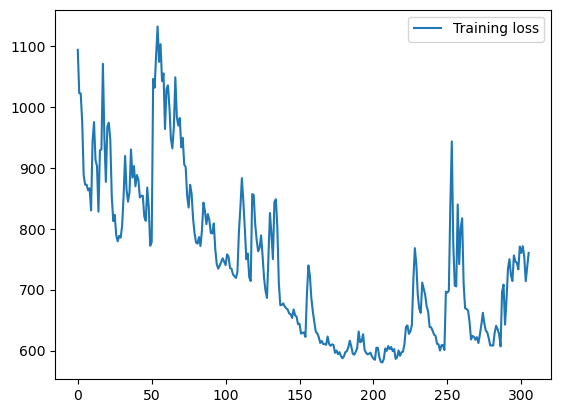

In [99]:
history_hk1 = model_hk1.fit(trainX_hk1, trainY_hk1,validation_data = (testX_hk1,testY_hk1) ,epochs=1000, batch_size=200,verbose=1,callbacks =[es])
#validation_split=0.2,
plt.plot(history_hk1.history['loss'], label='Training loss')
#plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [100]:
prediction_hk1 = model_hk1.predict(testX_hk1) 
for _ in zip(prediction_hk1,testY_hk1):
    print(_)

91/91 [==============================] - 0s 2ms/step
(array([376.63818], dtype=float32), array([[1393.033333]]))
(array([371.00208], dtype=float32), array([[1355.555556]]))
(array([351.6684], dtype=float32), array([[1758.755556]]))
(array([351.37067], dtype=float32), array([[2251.755556]]))
(array([375.56287], dtype=float32), array([[2202.522222]]))
(array([356.26657], dtype=float32), array([[1494.588889]]))
(array([401.2312], dtype=float32), array([[1038.177778]]))
(array([426.6205], dtype=float32), array([[489.1555556]]))
(array([0.], dtype=float32), array([[307.5888889]]))
(array([244.21803], dtype=float32), array([[279.3888889]]))
(array([199.87111], dtype=float32), array([[1166.844444]]))
(array([348.87762], dtype=float32), array([[741.9055556]]))
(array([552.38], dtype=float32), array([[662.1166667]]))
(array([630.66565], dtype=float32), array([[1486.611111]]))
(array([152.21414], dtype=float32), array([[1089.488889]]))
(array([0.], dtype=float32), array([[651.7666667]]))
(array(

(array([515.3308], dtype=float32), array([[4488.161111]]))
(array([1463.3728], dtype=float32), array([[4544.094444]]))
(array([1676.6382], dtype=float32), array([[4559.644444]]))
(array([2430.0557], dtype=float32), array([[4556.505556]]))
(array([2929.3442], dtype=float32), array([[4473.511111]]))
(array([3356.9368], dtype=float32), array([[4505.644444]]))
(array([3656.7205], dtype=float32), array([[4490.5]]))
(array([4170.479], dtype=float32), array([[4523.988889]]))
(array([3470.4], dtype=float32), array([[3881.005556]]))
(array([2828.7363], dtype=float32), array([[2933.577778]]))
(array([3214.3374], dtype=float32), array([[1348.038889]]))
(array([2214.7441], dtype=float32), array([[648.0722222]]))
(array([1087.4275], dtype=float32), array([[111.8611111]]))
(array([530.91907], dtype=float32), array([[8.21111111]]))
(array([0.], dtype=float32), array([[1.03888889]]))
(array([0.], dtype=float32), array([[45.09444444]]))
(array([0.], dtype=float32), array([[86.21666667]]))
(array([0.], 

(array([0.], dtype=float32), array([[31.97222222]]))
(array([0.], dtype=float32), array([[3.97777778]]))
(array([0.], dtype=float32), array([[0.]]))
(array([0.], dtype=float32), array([[0.]]))
(array([0.], dtype=float32), array([[0.]]))
(array([0.], dtype=float32), array([[0.]]))
(array([0.], dtype=float32), array([[0.]]))
(array([0.], dtype=float32), array([[0.]]))
(array([0.], dtype=float32), array([[0.]]))
(array([0.], dtype=float32), array([[108.0111111]]))
(array([369.16245], dtype=float32), array([[332.1055556]]))
(array([377.40558], dtype=float32), array([[107.0222222]]))
(array([381.14374], dtype=float32), array([[417.3777778]]))
(array([390.56818], dtype=float32), array([[568.5]]))
(array([392.18704], dtype=float32), array([[482.2611111]]))
(array([399.1657], dtype=float32), array([[870.7777778]]))
(array([382.88147], dtype=float32), array([[923.5]]))
(array([381.2317], dtype=float32), array([[881.9333333]]))
(array([404.04312], dtype=float32), array([[1186.061111]]))
(array([

(array([401.77737], dtype=float32), array([[2302.25]]))
(array([379.71332], dtype=float32), array([[2583.355556]]))
(array([380.1639], dtype=float32), array([[2444.55]]))
(array([448.7988], dtype=float32), array([[2450.744444]]))
(array([607.7219], dtype=float32), array([[2429.561111]]))
(array([1209.6293], dtype=float32), array([[794.8277778]]))
(array([1152.5619], dtype=float32), array([[0.]]))
(array([707.95154], dtype=float32), array([[84.59444444]]))
(array([342.14935], dtype=float32), array([[32.01111111]]))
(array([657.36945], dtype=float32), array([[958.8333333]]))
(array([860.22815], dtype=float32), array([[1643.944444]]))
(array([857.66394], dtype=float32), array([[1909.722222]]))
(array([265.96283], dtype=float32), array([[1524.238889]]))
(array([180.63507], dtype=float32), array([[1539.538889]]))
(array([167.5288], dtype=float32), array([[2487.477778]]))
(array([2466.574], dtype=float32), array([[1700.977778]]))
(array([2224.214], dtype=float32), array([[1678.933333]]))
(ar

(array([688.9271], dtype=float32), array([[1430.888889]]))
(array([230.4527], dtype=float32), array([[1349.55]]))
(array([0.], dtype=float32), array([[1542.5]]))
(array([417.70575], dtype=float32), array([[1510.938889]]))
(array([1422.4197], dtype=float32), array([[2292.377778]]))
(array([2491.253], dtype=float32), array([[842.0055556]]))
(array([1034.6704], dtype=float32), array([[1398.683333]]))
(array([513.7806], dtype=float32), array([[2171.022222]]))
(array([923.4254], dtype=float32), array([[1534.666667]]))
(array([638.10425], dtype=float32), array([[2374.922222]]))
(array([914.58014], dtype=float32), array([[3465.983333]]))
(array([471.8229], dtype=float32), array([[3325.666667]]))
(array([3194.0293], dtype=float32), array([[3864.183333]]))
(array([3556.4026], dtype=float32), array([[3378.683333]]))
(array([3407.312], dtype=float32), array([[4002.188889]]))
(array([3935.9639], dtype=float32), array([[3538.361111]]))
(array([2830.7063], dtype=float32), array([[2668.744444]]))
(ar

(array([0.], dtype=float32), array([[278.8611111]]))
(array([485.10382], dtype=float32), array([[3331.105556]]))
(array([1027.926], dtype=float32), array([[4549.933333]]))
(array([827.4951], dtype=float32), array([[4275.166667]]))
(array([2315.3145], dtype=float32), array([[3815.338889]]))
(array([2919.8533], dtype=float32), array([[3070.516667]]))
(array([3201.7812], dtype=float32), array([[3964.45]]))
(array([3825.6035], dtype=float32), array([[3679.1]]))
(array([2651.5425], dtype=float32), array([[2830.772222]]))


NameError: name 'model_score' is not defined

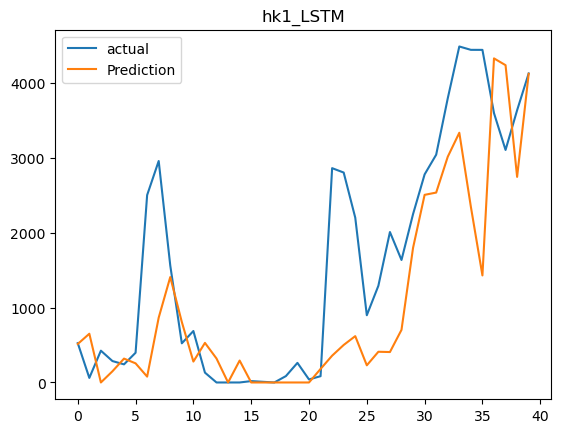

In [101]:
# LSTM
n=20
m=60
plt.title('hk1_LSTM')

plt.plot(testY_hk1[n:m].reshape(-1,1),label = 'actual')
plt.plot(prediction_hk1[n:m], label = 'Prediction')
plt.legend()
print(model_score(testY_hk1.reshape(-1,1),prediction_hk1))

In [1584]:
model_hk2 = Sequential()
model_hk2.add(LSTM(64, activation='relu', input_shape=(trainX_hk2.shape[1], trainX_hk2.shape[2]),return_sequences=True))
                             #return_sequences=True))
model_hk2.add(LSTM(32, activation='relu', return_sequences=True))
#model.add(LSTM(64, activation='relu', return_sequences=True))
#model.add(Bidirectional(LSTM(24, activation='relu', return_sequences=False)))
model_hk2.add(Dropout(0.2))
model_hk2.add(Flatten())
model_hk2.add(Dense(trainY.shape[1], activation='relu'))#, return_sequences=False))
#model.add(Dense(32, activation='relu'))#, return_sequences=False))
#model.add(Dense(8, activation='relu'))#, return_sequences=False))
#model.add(Dense(trainY.shape[1]))

model_hk2.compile(optimizer='adam', loss='mae')

Epoch 1/1000
44/44 [==============================] - 3s 24ms/step - loss: 3218.7954 - val_loss: 1020.9089
Epoch 2/1000
44/44 [==============================] - 1s 17ms/step - loss: 2884.2471 - val_loss: 933.9708
Epoch 3/1000
44/44 [==============================] - 1s 18ms/step - loss: 2788.2073 - val_loss: 1014.5601
Epoch 4/1000
44/44 [==============================] - 1s 18ms/step - loss: 2726.2327 - val_loss: 1017.1833
Epoch 5/1000
44/44 [==============================] - 1s 16ms/step - loss: 2745.8071 - val_loss: 1067.2509
Epoch 6/1000
44/44 [==============================] - 1s 16ms/step - loss: 2641.7458 - val_loss: 953.0197
Epoch 7/1000
44/44 [==============================] - 1s 16ms/step - loss: 2600.9106 - val_loss: 917.2618
Epoch 8/1000
44/44 [==============================] - 1s 17ms/step - loss: 2575.0366 - val_loss: 896.9729
Epoch 9/1000
44/44 [==============================] - 1s 16ms/step - loss: 2645.4146 - val_loss: 1043.1932
Epoch 10/1000
44/44 [====================

44/44 [==============================] - 1s 18ms/step - loss: 1418.8549 - val_loss: 364.9974
Epoch 154/1000
44/44 [==============================] - 1s 18ms/step - loss: 1413.7305 - val_loss: 353.2584
Epoch 155/1000
44/44 [==============================] - 1s 19ms/step - loss: 1376.9613 - val_loss: 403.0703
Epoch 156/1000
44/44 [==============================] - 1s 18ms/step - loss: 1393.5276 - val_loss: 387.2436
Epoch 157/1000
44/44 [==============================] - 1s 18ms/step - loss: 1437.0356 - val_loss: 405.8729
Epoch 158/1000
44/44 [==============================] - 1s 18ms/step - loss: 1423.3555 - val_loss: 349.9948
Epoch 159/1000
44/44 [==============================] - 1s 18ms/step - loss: 1428.2710 - val_loss: 351.2642
Epoch 160/1000
44/44 [==============================] - 1s 18ms/step - loss: 1403.0354 - val_loss: 348.7860
Epoch 161/1000
44/44 [==============================] - 1s 18ms/step - loss: 1399.7316 - val_loss: 422.0519
Epoch 162/1000
44/44 [=====================

Epoch 229/1000
44/44 [==============================] - 1s 19ms/step - loss: 1367.7489 - val_loss: 344.3895
Epoch 230/1000
44/44 [==============================] - 1s 20ms/step - loss: 1352.3497 - val_loss: 372.1827
Epoch 231/1000
44/44 [==============================] - 1s 19ms/step - loss: 1349.2314 - val_loss: 371.9836
Epoch 232/1000
44/44 [==============================] - 1s 19ms/step - loss: 1348.6145 - val_loss: 375.1037
Epoch 233/1000
44/44 [==============================] - 1s 19ms/step - loss: 1359.7723 - val_loss: 337.7675
Epoch 234/1000
44/44 [==============================] - 1s 19ms/step - loss: 1348.5994 - val_loss: 362.7620
Epoch 235/1000
44/44 [==============================] - 1s 19ms/step - loss: 1349.4368 - val_loss: 359.2233
Epoch 236/1000
44/44 [==============================] - 1s 19ms/step - loss: 1334.9393 - val_loss: 430.6884
Epoch 237/1000
44/44 [==============================] - 1s 19ms/step - loss: 1334.1254 - val_loss: 336.1835
Epoch 238/1000
44/44 [======

Epoch 305/1000
44/44 [==============================] - 1s 21ms/step - loss: 1305.0930 - val_loss: 346.3640
Epoch 306/1000
44/44 [==============================] - 1s 20ms/step - loss: 1280.9326 - val_loss: 350.3969
Epoch 307/1000
44/44 [==============================] - 1s 20ms/step - loss: 1293.9191 - val_loss: 332.8072
Epoch 308/1000
44/44 [==============================] - 1s 20ms/step - loss: 1276.3755 - val_loss: 361.4425
Epoch 309/1000
44/44 [==============================] - 1s 20ms/step - loss: 1276.4607 - val_loss: 388.8001
Epoch 310/1000
44/44 [==============================] - 1s 20ms/step - loss: 1296.9720 - val_loss: 341.7682
Epoch 311/1000
44/44 [==============================] - 1s 20ms/step - loss: 1282.4143 - val_loss: 340.8779
Epoch 312/1000
44/44 [==============================] - 1s 20ms/step - loss: 1270.3119 - val_loss: 410.1830
Epoch 313/1000
44/44 [==============================] - 1s 20ms/step - loss: 1274.9780 - val_loss: 342.0404
Epoch 314/1000
44/44 [======

Epoch 381/1000
44/44 [==============================] - 1s 20ms/step - loss: 1322.7092 - val_loss: 358.4431
Epoch 382/1000
44/44 [==============================] - 1s 20ms/step - loss: 1372.5498 - val_loss: 360.5193
Epoch 383/1000
44/44 [==============================] - 1s 20ms/step - loss: 1553.3477 - val_loss: 405.2044
Epoch 384/1000
44/44 [==============================] - 1s 20ms/step - loss: 1738.5767 - val_loss: 446.1291
Epoch 385/1000
44/44 [==============================] - 1s 20ms/step - loss: 1520.4249 - val_loss: 414.0580
Epoch 386/1000
44/44 [==============================] - 1s 20ms/step - loss: 1488.6840 - val_loss: 364.1995
Epoch 387/1000
44/44 [==============================] - 1s 20ms/step - loss: 1521.8911 - val_loss: 366.5483
Epoch 388/1000
44/44 [==============================] - 1s 20ms/step - loss: 1603.0674 - val_loss: 433.4677
Epoch 389/1000
44/44 [==============================] - 1s 20ms/step - loss: 1527.9728 - val_loss: 362.9913
Epoch 390/1000
44/44 [======

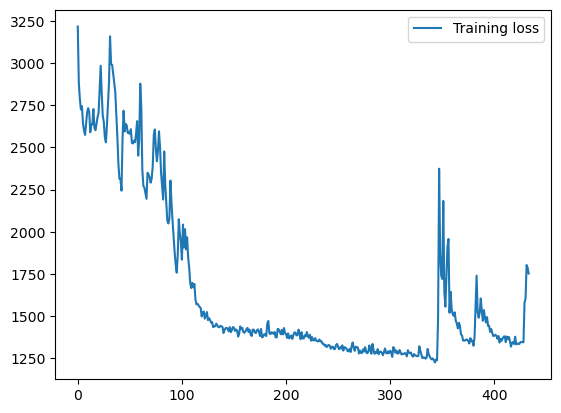

In [1585]:
history_hk2 = model_hk2.fit(trainX_hk2, trainY_hk2,validation_data = (testX_hk2,testY_hk2) ,epochs=1000, batch_size=200,verbose=1,callbacks =[es])
#validation_split=0.2,
plt.plot(history_hk2.history['loss'], label='Training loss')
#plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [1586]:
prediction_hk2 = model_hk2.predict(testX_hk2) 
for _ in zip(prediction_hk2,testY_hk2):
    print(_)

91/91 [==============================] - 1s 3ms/step
(array([696.90424], dtype=float32), array([[1393.033333]]))
(array([962.6295], dtype=float32), array([[1355.555556]]))
(array([1090.6274], dtype=float32), array([[1758.755556]]))
(array([1431.2333], dtype=float32), array([[2251.755556]]))
(array([2202.0535], dtype=float32), array([[2202.522222]]))
(array([2667.411], dtype=float32), array([[1494.588889]]))
(array([2733.4456], dtype=float32), array([[1038.177778]]))
(array([1308.8927], dtype=float32), array([[489.1555556]]))
(array([804.0255], dtype=float32), array([[307.5888889]]))
(array([166.57129], dtype=float32), array([[279.3888889]]))
(array([0.], dtype=float32), array([[1166.844444]]))
(array([890.7502], dtype=float32), array([[741.9055556]]))
(array([271.94547], dtype=float32), array([[662.1166667]]))
(array([371.66455], dtype=float32), array([[1486.611111]]))
(array([1164.8212], dtype=float32), array([[1089.488889]]))
(array([796.61444], dtype=float32), array([[651.7666667]])

(array([661.926], dtype=float32), array([[3.77777778]]))
(array([159.23195], dtype=float32), array([[0.]]))
(array([0.], dtype=float32), array([[0.]]))
(array([0.], dtype=float32), array([[27.92777778]]))
(array([0.], dtype=float32), array([[68.10555556]]))
(array([0.], dtype=float32), array([[3.01111111]]))
(array([0.], dtype=float32), array([[33.13333333]]))
(array([0.], dtype=float32), array([[110.8]]))
(array([58.834854], dtype=float32), array([[3.36111111]]))
(array([31.039017], dtype=float32), array([[0.]]))
(array([0.], dtype=float32), array([[396.6166667]]))
(array([320.87756], dtype=float32), array([[433.4666667]]))
(array([342.36755], dtype=float32), array([[900.6388889]]))
(array([608.53766], dtype=float32), array([[1364.333333]]))
(array([979.9643], dtype=float32), array([[241.9555556]]))
(array([133.14485], dtype=float32), array([[0.]]))
(array([65.04845], dtype=float32), array([[0.]]))
(array([0.], dtype=float32), array([[0.]]))
(array([0.], dtype=float32), array([[0.]]))

(array([942.85516], dtype=float32), array([[692.6444444]]))
(array([374.75244], dtype=float32), array([[440.2611111]]))
(array([352.2978], dtype=float32), array([[729.8944444]]))
(array([527.69403], dtype=float32), array([[1454.394444]]))
(array([1038.8995], dtype=float32), array([[1390.327778]]))
(array([961.97076], dtype=float32), array([[1274.45]]))
(array([945.95496], dtype=float32), array([[1028.233333]]))
(array([740.96246], dtype=float32), array([[1063.361111]]))
(array([725.3172], dtype=float32), array([[900.7333333]]))
(array([511.95117], dtype=float32), array([[1028.761111]]))
(array([661.9353], dtype=float32), array([[1177.733333]]))
(array([662.082], dtype=float32), array([[1188.211111]]))
(array([771.50006], dtype=float32), array([[1206.488889]]))
(array([855.48456], dtype=float32), array([[639.7944444]]))
(array([355.51587], dtype=float32), array([[184.2722222]]))
(array([42.4619], dtype=float32), array([[19.21666667]]))
(array([0.], dtype=float32), array([[81.13333333]])

(array([1162.7893], dtype=float32), array([[764.15]]))
(array([928.95953], dtype=float32), array([[2302.25]]))
(array([2591.4097], dtype=float32), array([[2583.355556]]))
(array([3082.607], dtype=float32), array([[2444.55]]))
(array([3530.9473], dtype=float32), array([[2450.744444]]))
(array([3679.9536], dtype=float32), array([[2429.561111]]))
(array([1919.8954], dtype=float32), array([[794.8277778]]))
(array([1750.3517], dtype=float32), array([[0.]]))
(array([304.7837], dtype=float32), array([[84.59444444]]))
(array([0.], dtype=float32), array([[32.01111111]]))
(array([0.], dtype=float32), array([[958.8333333]]))
(array([676.44135], dtype=float32), array([[1643.944444]]))
(array([1035.534], dtype=float32), array([[1909.722222]]))
(array([1428.5157], dtype=float32), array([[1524.238889]]))
(array([1412.481], dtype=float32), array([[1539.538889]]))
(array([1354.2985], dtype=float32), array([[2487.477778]]))
(array([2090.598], dtype=float32), array([[1700.977778]]))
(array([1357.3969], d

(array([476.20624], dtype=float32), array([[258.6722222]]))
(array([303.191], dtype=float32), array([[275.2444444]]))
(array([51.291153], dtype=float32), array([[84.61666667]]))
(array([0.], dtype=float32), array([[0.]]))
(array([66.17027], dtype=float32), array([[0.]]))
(array([0.], dtype=float32), array([[278.8611111]]))
(array([261.63855], dtype=float32), array([[3331.105556]]))
(array([2219.0242], dtype=float32), array([[4549.933333]]))
(array([3133.3584], dtype=float32), array([[4275.166667]]))
(array([5886.941], dtype=float32), array([[3815.338889]]))
(array([5887.641], dtype=float32), array([[3070.516667]]))
(array([5721.649], dtype=float32), array([[3964.45]]))
(array([5768.812], dtype=float32), array([[3679.1]]))
(array([4445.0923], dtype=float32), array([[2830.772222]]))


R2 score: 0.7109590817538545
MAE Loss:  440.7498294566232
(0.7109590817538545, 440.7498294566232)


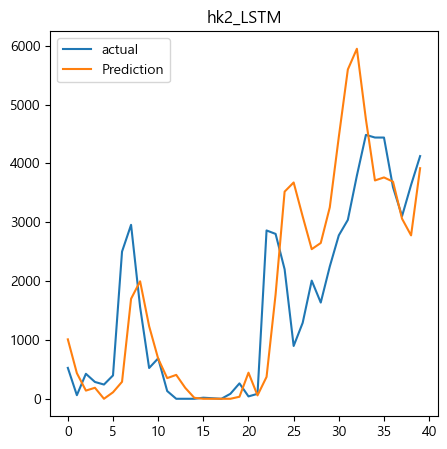

In [1766]:
# LSTM
n=20
m=60
plt.title('hk2_LSTM')

plt.plot(testY_hk2[n:m].reshape(-1,1),label = 'actual')
plt.plot(prediction_hk2[n:m], label = 'Prediction')
plt.legend()
print(model_score(testY_hk2.reshape(-1,1),prediction_hk2))

In [1554]:
model_ss = Sequential()
model_ss.add(LSTM(64, activation='relu', input_shape=(trainX_ss.shape[1], trainX_ss.shape[2]),return_sequences=True))
                             #return_sequences=True))
model_ss.add(LSTM(32, activation='relu', return_sequences=True))
#model.add(LSTM(64, activation='relu', return_sequences=True))
#model.add(Bidirectional(LSTM(24, activation='relu', return_sequences=False)))
model_ss.add(Dropout(0.2))
model_ss.add(Flatten())
model_ss.add(Dense(trainY.shape[1], activation='relu'))#, return_sequences=False))
#model.add(Dense(32, activation='relu'))#, return_sequences=False))
#model.add(Dense(8, activation='relu'))#, return_sequences=False))
#model.add(Dense(trainY.shape[1]))

model_ss.compile(optimizer='adam', loss='mae')

Epoch 1/1000
44/44 [==============================] - 3s 23ms/step - loss: 4264.0127 - val_loss: 4115.4971
Epoch 2/1000
44/44 [==============================] - 1s 16ms/step - loss: 3886.9080 - val_loss: 3931.1794
Epoch 3/1000
44/44 [==============================] - 1s 16ms/step - loss: 3613.0330 - val_loss: 3689.5146
Epoch 4/1000
44/44 [==============================] - 1s 16ms/step - loss: 3547.4866 - val_loss: 3704.5022
Epoch 5/1000
44/44 [==============================] - 1s 17ms/step - loss: 3618.6704 - val_loss: 4093.5056
Epoch 6/1000
44/44 [==============================] - 1s 16ms/step - loss: 3772.6355 - val_loss: 3695.8420
Epoch 7/1000
44/44 [==============================] - 1s 17ms/step - loss: 3546.9741 - val_loss: 3621.1006
Epoch 8/1000
44/44 [==============================] - 1s 18ms/step - loss: 3446.2356 - val_loss: 3621.2278
Epoch 9/1000
44/44 [==============================] - 1s 19ms/step - loss: 3866.9978 - val_loss: 4076.4609
Epoch 10/1000
44/44 [================

Epoch 77/1000
44/44 [==============================] - 1s 17ms/step - loss: 3573.8179 - val_loss: 3569.1865
Epoch 78/1000
44/44 [==============================] - 1s 18ms/step - loss: 3441.1028 - val_loss: 3476.5608
Epoch 79/1000
44/44 [==============================] - 1s 17ms/step - loss: 3477.4580 - val_loss: 3539.6028
Epoch 80/1000
44/44 [==============================] - 1s 17ms/step - loss: 3466.3176 - val_loss: 3262.9858
Epoch 81/1000
44/44 [==============================] - 1s 17ms/step - loss: 3473.4851 - val_loss: 3646.4607
Epoch 82/1000
44/44 [==============================] - 1s 17ms/step - loss: 3401.2886 - val_loss: 3434.0085
Epoch 83/1000
44/44 [==============================] - 1s 17ms/step - loss: 3385.6316 - val_loss: 3309.4802
Epoch 84/1000
44/44 [==============================] - 1s 17ms/step - loss: 3332.7078 - val_loss: 3283.4182
Epoch 85/1000
44/44 [==============================] - 1s 17ms/step - loss: 3439.6074 - val_loss: 3528.1821
Epoch 86/1000
44/44 [=======

44/44 [==============================] - 1s 19ms/step - loss: 2337.9304 - val_loss: 2246.6868
Epoch 228/1000
44/44 [==============================] - 1s 20ms/step - loss: 2347.6338 - val_loss: 2243.1943
Epoch 229/1000
44/44 [==============================] - 1s 20ms/step - loss: 2317.3098 - val_loss: 2219.7639
Epoch 230/1000
44/44 [==============================] - 1s 19ms/step - loss: 2294.3208 - val_loss: 2236.7898
Epoch 231/1000
44/44 [==============================] - 1s 19ms/step - loss: 2308.3379 - val_loss: 2218.7305
Epoch 232/1000
44/44 [==============================] - 1s 19ms/step - loss: 2320.5906 - val_loss: 2376.9792
Epoch 233/1000
44/44 [==============================] - 1s 19ms/step - loss: 2288.0798 - val_loss: 2348.7336
Epoch 234/1000
44/44 [==============================] - 1s 19ms/step - loss: 2287.2041 - val_loss: 2196.5879
Epoch 235/1000
44/44 [==============================] - 1s 19ms/step - loss: 2286.9675 - val_loss: 2203.9939
Epoch 236/1000
44/44 [============

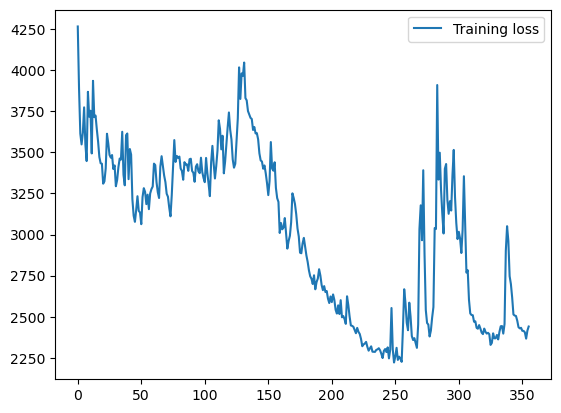

In [1555]:
history_ss = model_ss.fit(trainX_ss, trainY_ss,validation_data = (testX_ss,testY_ss) ,epochs=1000, batch_size=200,verbose=1,callbacks =[es])
#validation_split=0.2,
plt.plot(history_ss.history['loss'], label='Training loss')
#plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [1556]:
prediction_ss = model_ss.predict(testX_ss) 
for _ in zip(prediction_ss,testY_ss):
    print(_)

91/91 [==============================] - 1s 3ms/step
(array([968.7529], dtype=float32), array([[1610.262]]))
(array([972.85504], dtype=float32), array([[8492.419333]]))
(array([1566.9359], dtype=float32), array([[13345.77133]]))
(array([7410.1997], dtype=float32), array([[11781.71333]]))
(array([6842.8574], dtype=float32), array([[11699.203]]))
(array([13932.779], dtype=float32), array([[10247.519]]))
(array([7259.7524], dtype=float32), array([[8715.345]]))
(array([13995.238], dtype=float32), array([[6992.309]]))
(array([7892.527], dtype=float32), array([[7158.044333]]))
(array([7935.456], dtype=float32), array([[9287.556667]]))
(array([7831.3564], dtype=float32), array([[13307.53233]]))
(array([8306.707], dtype=float32), array([[15576.27133]]))
(array([10125.544], dtype=float32), array([[5865.019]]))
(array([6088.533], dtype=float32), array([[5443.822]]))
(array([4516.463], dtype=float32), array([[2711.306333]]))
(array([2238.2505], dtype=float32), array([[5682.105]]))
(array([4271.61

(array([6629.6455], dtype=float32), array([[9024.011]]))
(array([6181.469], dtype=float32), array([[8940.737667]]))
(array([7373.933], dtype=float32), array([[9090.815333]]))
(array([7535.0815], dtype=float32), array([[11190.21233]]))
(array([9304.393], dtype=float32), array([[15373.579]]))
(array([13793.404], dtype=float32), array([[13925.212]]))
(array([13450.97], dtype=float32), array([[9724.044]]))
(array([9622.376], dtype=float32), array([[6075.659667]]))
(array([5402.392], dtype=float32), array([[1828.228]]))
(array([3258.6296], dtype=float32), array([[813.4886667]]))
(array([2210.3394], dtype=float32), array([[1120.019333]]))
(array([1287.248], dtype=float32), array([[665.927]]))
(array([397.60272], dtype=float32), array([[7521.987667]]))
(array([5748.292], dtype=float32), array([[13441.609]]))
(array([11728.294], dtype=float32), array([[6112.72]]))
(array([5942.0835], dtype=float32), array([[3962.351]]))
(array([3884.0103], dtype=float32), array([[10777.69833]]))
(array([9784.7

(array([2174.0732], dtype=float32), array([[3489.646667]]))
(array([4557.8867], dtype=float32), array([[219.9176667]]))
(array([3263.657], dtype=float32), array([[1355.848667]]))
(array([3280.628], dtype=float32), array([[2316.491333]]))
(array([4126.544], dtype=float32), array([[2086.352]]))
(array([3757.3271], dtype=float32), array([[5642.077]]))
(array([3356.877], dtype=float32), array([[11335.14367]]))
(array([5525.2305], dtype=float32), array([[11052.27467]]))
(array([8771.74], dtype=float32), array([[3539.407333]]))
(array([7665.3057], dtype=float32), array([[7197.123333]]))
(array([5781.523], dtype=float32), array([[5473.970667]]))
(array([5535.8687], dtype=float32), array([[6145.759]]))
(array([5932.1655], dtype=float32), array([[4349.906333]]))
(array([4518.5713], dtype=float32), array([[4016.211333]]))
(array([3701.9941], dtype=float32), array([[4917.465667]]))
(array([4984.6523], dtype=float32), array([[6166.881667]]))
(array([4886.374], dtype=float32), array([[4784.069667]]

(array([1539.783], dtype=float32), array([[2527.676]]))
(array([1954.4318], dtype=float32), array([[1842.321333]]))
(array([1529.483], dtype=float32), array([[1096.971333]]))
(array([1023.258], dtype=float32), array([[2167.795333]]))
(array([1925.384], dtype=float32), array([[3163.705667]]))
(array([2420.0713], dtype=float32), array([[3278.397667]]))
(array([2609.941], dtype=float32), array([[4338.764]]))
(array([3481.521], dtype=float32), array([[2845.759333]]))
(array([2408.2534], dtype=float32), array([[1894.223]]))
(array([1895.0027], dtype=float32), array([[3210.456667]]))
(array([2768.3755], dtype=float32), array([[2989.898333]]))
(array([2700.2517], dtype=float32), array([[2264.014333]]))
(array([2374.5522], dtype=float32), array([[3312.336333]]))
(array([2725.7876], dtype=float32), array([[3666.053667]]))
(array([2273.76], dtype=float32), array([[2550.814333]]))
(array([2858.4412], dtype=float32), array([[1610.908]]))
(array([1761.9973], dtype=float32), array([[1508.670667]]))


(array([9348.076], dtype=float32), array([[13875.73833]]))
(array([12153.172], dtype=float32), array([[12110.18367]]))
(array([11557.869], dtype=float32), array([[15169.435]]))
(array([13223.284], dtype=float32), array([[11739.059]]))
(array([11316.62], dtype=float32), array([[7735.263667]]))
(array([6771.1245], dtype=float32), array([[4264.995333]]))
(array([4017.724], dtype=float32), array([[4069.992333]]))
(array([3285.498], dtype=float32), array([[3655.306]]))
(array([2498.5317], dtype=float32), array([[3450.918]]))
(array([2382.9548], dtype=float32), array([[3140.512]]))
(array([2049.2773], dtype=float32), array([[3267.788333]]))
(array([2295.0269], dtype=float32), array([[1751.588667]]))
(array([1320.7133], dtype=float32), array([[1619.730333]]))
(array([1187.9635], dtype=float32), array([[3087.971]]))
(array([2588.2588], dtype=float32), array([[3018.445333]]))
(array([2289.3918], dtype=float32), array([[3222.736667]]))
(array([2481.4226], dtype=float32), array([[5251.572667]]))


R2 score: 0.6343281004365349
MAE Loss:  2398.5622765241933
(0.6343281004365349, 2398.5622765241933)


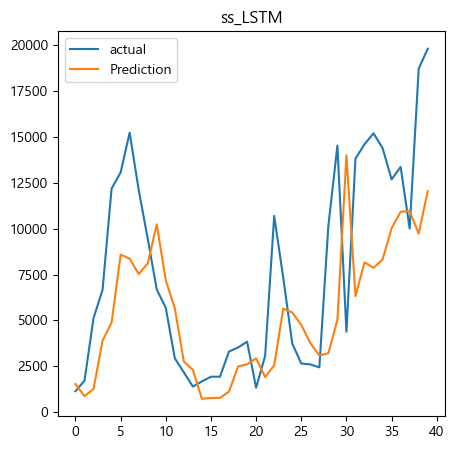

In [1765]:
# LSTM
n=20
m=60
plt.title('ss_LSTM')

plt.plot(testY_ss[n:m].reshape(-1,1),label = 'actual')
plt.plot(prediction_ss[n:m], label = 'Prediction')
plt.legend()
print(model_score(testY_ss.reshape(-1,1),prediction_ss))

In [1527]:
trainX_hk1.shape, trainY_hk1.shape

((8651, 15, 13), (8651, 1, 1))

In [921]:
testX.shape , testY.shape

((2906, 14, 5), (2906, 1))

In [1522]:
train_dataset_hk1 = torch.utils.data.TensorDataset(torch.from_numpy(trainX_hk1).float(),torch.from_numpy(trainY_hk1).float())

In [1523]:
test_dataset_hk1 = torch.utils.data.TensorDataset(torch.from_numpy(testX_hk1).float(),torch.from_numpy(testY_hk1).float())

In [1524]:
train_loader_hk1 = DataLoader(train_dataset_hk1,batch_size= batch_size,shuffle = False, num_workers=0)

In [1525]:
test_loader_hk1 = DataLoader(test_dataset_hk1,batch_size= batch_size,shuffle = False, num_workers=0)

In [1589]:
train_dataset_hk2 = torch.utils.data.TensorDataset(torch.from_numpy(trainX_hk2).float(),torch.from_numpy(trainY_hk2).float())
test_dataset_hk2 = torch.utils.data.TensorDataset(torch.from_numpy(testX_hk2).float(),torch.from_numpy(testY_hk2).float())

In [1590]:
train_loader_hk2 = DataLoader(train_dataset_hk2,batch_size= batch_size,shuffle = False, num_workers=0)
test_loader_hk2 = DataLoader(test_dataset_hk2,batch_size= batch_size,shuffle = False, num_workers=0)

In [1591]:
train_dataset_ss = torch.utils.data.TensorDataset(torch.from_numpy(trainX_ss).float(),torch.from_numpy(trainY_ss).float())
test_dataset_ss = torch.utils.data.TensorDataset(torch.from_numpy(testX_ss).float(),torch.from_numpy(testY_ss).float())

In [1592]:
train_loader_ss = DataLoader(train_dataset_ss,batch_size= batch_size,shuffle = False, num_workers=0)
test_loader_ss = DataLoader(test_dataset_ss,batch_size= batch_size,shuffle = False, num_workers=0)

In [1615]:
n_epoch = 1000  # 100, 300, 500
batch_size = 16
hidden_size = 16
num_layers = 1
history_length = 14
nhead = 8  # 2, 4, 8
d_model = hidden_size * nhead
dim_feedforward = d_model * 4

In [1616]:
n_features = 13

In [1635]:
model_hk1 = SimpleTransformer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, input_size=n_features,
                            hidden_size=hidden_size, dropout=0.1, num_layers=num_layers)

In [1618]:
model_hk2 = SimpleTransformer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, input_size=n_features,
                            hidden_size=hidden_size, dropout=0.1, num_layers=num_layers)

In [1666]:
model_ss = SimpleTransformer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, input_size=n_features,
                            hidden_size=hidden_size, dropout=0.1, num_layers=num_layers)

In [1665]:
def model_score(y_label, y_pred, target):
    try:
        print("R2 score:", sklearn.metrics.r2_score(y_label, y_pred))
        print("MAE Loss: ", sklearn.metrics.mean_absolute_error(y_label, y_pred))
    except Exception as e:
        print(e)

In [1637]:
#hk1
lr = 0.001
criterion = nn.L1Loss()
optimizer = optim.AdamW(model_hk1.parameters(), lr=lr)
train_loss_hk1, val_loss_hk1 = trainer(train_loader_hk1, test_loader_hk1, model_hk1, criterion, optimizer, target=target, n_epoch=n_epoch, PATH=PATH, isEDR=isEDR)


Epoch 0/1000
TRAIN
R2 score: -0.6819128760942759
MAE Loss:  1212.4176619681277
Validation
R2 score: -0.5004336390898594
MAE Loss:  1045.1036383642875
Epoch 1/1000
TRAIN
R2 score: -0.4718985247147467
MAE Loss:  1113.6747500153429
Validation
R2 score: -0.25447413129199536
MAE Loss:  931.4872468898377
Epoch 2/1000
TRAIN
R2 score: -0.20059990442883335
MAE Loss:  986.651387337773
Validation
R2 score: 0.0028199686508803
MAE Loss:  808.5535658448345
Epoch 3/1000
TRAIN
R2 score: 0.056479609604282
MAE Loss:  870.6812970779466
Validation
R2 score: 0.23347189652314582
MAE Loss:  702.0572808377381
Epoch 4/1000
TRAIN
R2 score: 0.27455979243312856
MAE Loss:  763.757263247713
Validation
R2 score: 0.41325601644460397
MAE Loss:  613.8847051093044
Epoch 5/1000
TRAIN
R2 score: 0.44093861603586426
MAE Loss:  674.5980791186524
Validation
R2 score: 0.545786656908033
MAE Loss:  549.1826355038355
Epoch 6/1000
TRAIN
R2 score: 0.5675035936656876
MAE Loss:  600.0361550499915
Validation
R2 score: 0.63989368427332

R2 score: 0.8406409011358287
MAE Loss:  328.0069011132581
Epoch 56/1000
TRAIN
R2 score: 0.8158366896672827
MAE Loss:  384.47684860168863
Validation
R2 score: 0.8496235005091736
MAE Loss:  318.0893163617912
Epoch 57/1000
TRAIN
R2 score: 0.8171984180012167
MAE Loss:  382.97117865573927
Validation
R2 score: 0.851988199815737
MAE Loss:  314.8272548474538
Epoch 58/1000
TRAIN
R2 score: 0.8166252244834924
MAE Loss:  383.9269975947619
Validation
R2 score: 0.8493685945502272
MAE Loss:  315.6058164701071
Epoch 59/1000
TRAIN
R2 score: 0.8157369167135576
MAE Loss:  384.92950847172045
Validation
R2 score: 0.842110480912021
MAE Loss:  322.1032416178545
Epoch 60/1000
TRAIN
R2 score: 0.814688446563644
MAE Loss:  384.95918252035835
Validation
R2 score: 0.8457769895463794
MAE Loss:  318.30066279980025
Epoch 61/1000
TRAIN
R2 score: 0.8165333806516007
MAE Loss:  383.7435406981855
Validation
R2 score: 0.8480640047206848
MAE Loss:  321.4038621172924
Epoch 62/1000
TRAIN
R2 score: 0.8159533122965029
MAE Loss:

R2 score: 0.8201372284906228
MAE Loss:  379.30363424611517
Validation
R2 score: 0.8485622510964985
MAE Loss:  315.81627775801286
Epoch 112/1000
TRAIN
R2 score: 0.8178548327704434
MAE Loss:  380.6297980820791
Validation
R2 score: 0.8507393424053612
MAE Loss:  316.4231743455626
Epoch 113/1000
TRAIN
R2 score: 0.8201817888557588
MAE Loss:  378.94988114049625
Validation
R2 score: 0.8500668059783727
MAE Loss:  315.8150014595223
Epoch 114/1000
TRAIN
R2 score: 0.8201231540334502
MAE Loss:  378.7507632154924
Validation
R2 score: 0.8459099069451415
MAE Loss:  319.4347223766315
Epoch 115/1000
TRAIN
R2 score: 0.8186521726612396
MAE Loss:  379.38793576675755
Validation
R2 score: 0.8468684144340881
MAE Loss:  320.6030151898987
Epoch 116/1000
TRAIN
R2 score: 0.8195860801912884
MAE Loss:  378.70308074181844
Validation
R2 score: 0.8474344255206682
MAE Loss:  317.27881680318444
Epoch 117/1000
TRAIN
R2 score: 0.8164658168942677
MAE Loss:  381.0929167703743
Validation
R2 score: 0.843411257257815
MAE Loss:

R2 score: 0.8487447181613356
MAE Loss:  319.03502770808757
Epoch 167/1000
TRAIN
R2 score: 0.8205571568988742
MAE Loss:  376.85585183706496
Validation
R2 score: 0.8492854430369674
MAE Loss:  317.44822062109046
Epoch 168/1000
TRAIN
R2 score: 0.8195963731199197
MAE Loss:  377.2128785231936
Validation
R2 score: 0.853256059719294
MAE Loss:  314.2741179866014
Epoch 169/1000
TRAIN
R2 score: 0.8205887064989662
MAE Loss:  376.5507267254902
Validation
R2 score: 0.8511321710263271
MAE Loss:  317.2548929706165
Epoch 170/1000
TRAIN
R2 score: 0.8226257772714662
MAE Loss:  374.61559651802213
Validation
R2 score: 0.8494133601633117
MAE Loss:  318.04681177566823
Epoch 171/1000
TRAIN
R2 score: 0.8212623738930724
MAE Loss:  375.98662842028665
Validation
R2 score: 0.8550958499907406
MAE Loss:  315.6100437596902
Epoch 172/1000
TRAIN
R2 score: 0.8208704215109085
MAE Loss:  376.25816231189526
Validation
R2 score: 0.8540594341819756
MAE Loss:  315.99007800779276
Epoch 173/1000
TRAIN
R2 score: 0.81968853244608

R2 score: 0.8212721405811194
MAE Loss:  377.46326692326744
Validation
R2 score: 0.8527800968625584
MAE Loss:  318.3120966518269
Epoch 223/1000
TRAIN
R2 score: 0.8231863418314511
MAE Loss:  373.7261356127812
Validation
R2 score: 0.8553849529372055
MAE Loss:  312.7879879965506
Epoch 224/1000
TRAIN
R2 score: 0.8227926101630268
MAE Loss:  374.088537000527
Validation
R2 score: 0.8558536322053147
MAE Loss:  312.88578382015174
Epoch 225/1000
TRAIN
R2 score: 0.8228938882848164
MAE Loss:  373.75757038445676
Validation
R2 score: 0.8558745007485399
MAE Loss:  313.79744336552494
Epoch 226/1000
TRAIN
R2 score: 0.8222062961366825
MAE Loss:  374.73431579278787
Validation
R2 score: 0.8566782088532301
MAE Loss:  321.595500288083
Epoch 227/1000
TRAIN
R2 score: 0.8219904753288549
MAE Loss:  374.3647461828073
Validation
R2 score: 0.8473501024224253
MAE Loss:  321.8062413055674
Epoch 228/1000
TRAIN
R2 score: 0.8215060967342194
MAE Loss:  376.26191641096125
Validation
R2 score: 0.8513802171620151
MAE Loss: 

R2 score: 0.8548697450036905
MAE Loss:  319.4335082554853
Epoch 278/1000
TRAIN
R2 score: 0.8230329630455527
MAE Loss:  373.2920783128511
Validation
R2 score: 0.8521631737026905
MAE Loss:  322.3820812457682
Epoch 279/1000
TRAIN
R2 score: 0.8232641511750982
MAE Loss:  373.480731570587
Validation
R2 score: 0.855308027385164
MAE Loss:  319.5787024925657
Epoch 280/1000
TRAIN
R2 score: 0.8256374412518696
MAE Loss:  371.8447168347684
Validation
R2 score: 0.8548853747073178
MAE Loss:  313.0769287223224
Epoch 281/1000
TRAIN
R2 score: 0.8239653916944384
MAE Loss:  372.75517651307285
Validation
R2 score: 0.854985668978494
MAE Loss:  319.1628980081048
Epoch 282/1000
TRAIN
R2 score: 0.8241971591352367
MAE Loss:  371.9961241122226
Validation
R2 score: 0.8577990813209564
MAE Loss:  314.8013836122908
Epoch 283/1000
TRAIN
R2 score: 0.8228123060963908
MAE Loss:  375.5449100615933
Validation
R2 score: 0.8523544884313039
MAE Loss:  315.41576042282753
Epoch 284/1000
TRAIN
R2 score: 0.8222009748231163
MAE L

R2 score: 0.822678596003803
MAE Loss:  375.1338611387966
Validation
R2 score: 0.8503204112113403
MAE Loss:  315.4056308548622
Epoch 334/1000
TRAIN
R2 score: 0.8230328311362626
MAE Loss:  373.4244484064097
Validation
R2 score: 0.8528955941629343
MAE Loss:  315.6909634554935
Epoch 335/1000
TRAIN
R2 score: 0.822657942245846
MAE Loss:  374.6461422922256
Validation
R2 score: 0.848963729033025
MAE Loss:  320.3461418623845
Epoch 336/1000
TRAIN
R2 score: 0.8226983817386101
MAE Loss:  374.27452204053924
Validation
R2 score: 0.8497324669903304
MAE Loss:  316.6137064500515
Epoch 337/1000
TRAIN
R2 score: 0.8235824113560373
MAE Loss:  372.2321234104582
Validation
R2 score: 0.8510686022011875
MAE Loss:  318.20084418192533
Epoch 338/1000
TRAIN
R2 score: 0.8242211750471702
MAE Loss:  374.0589694882742
Validation
R2 score: 0.8487479424457265
MAE Loss:  316.55965161242244
Epoch 339/1000
TRAIN
R2 score: 0.8235936058205684
MAE Loss:  373.506646695855
Validation
R2 score: 0.8551747033227282
MAE Loss:  314.

R2 score: 0.8539204092997046
MAE Loss:  315.1876982638917
Epoch 389/1000
TRAIN
R2 score: 0.8245566775370318
MAE Loss:  371.6512642344696
Validation
R2 score: 0.8513846667878253
MAE Loss:  317.3680566498083
Epoch 390/1000
TRAIN
R2 score: 0.8252553438163991
MAE Loss:  372.3781407750138
Validation
R2 score: 0.8479906041302013
MAE Loss:  317.5656690295279
Epoch 391/1000
TRAIN
R2 score: 0.8244544572647153
MAE Loss:  372.0396733476501
Validation
R2 score: 0.8539294743242997
MAE Loss:  316.0301295725363
Epoch 392/1000
TRAIN
R2 score: 0.8259856109602464
MAE Loss:  370.35058016477706
Validation
R2 score: 0.8501669844026926
MAE Loss:  316.53726831287554
Epoch 393/1000
TRAIN
R2 score: 0.8247374343542164
MAE Loss:  372.9821415258727
Validation
R2 score: 0.8503232872145638
MAE Loss:  320.2524586428951
Epoch 394/1000
TRAIN
R2 score: 0.8261724890682816
MAE Loss:  369.7978719408172
Validation
R2 score: 0.8509916389226453
MAE Loss:  316.92923654468404
Epoch 395/1000
TRAIN
R2 score: 0.8238071802195107
M

R2 score: 0.8249874789574286
MAE Loss:  371.2006412241834
Validation
R2 score: 0.8509578180853066
MAE Loss:  315.5175972235259
Epoch 445/1000
TRAIN
R2 score: 0.8249559136698411
MAE Loss:  373.2050220217733
Validation
R2 score: 0.8513064821498926
MAE Loss:  313.7382104556629
Epoch 446/1000
TRAIN
R2 score: 0.8237544601903117
MAE Loss:  373.4829976010524
Validation
R2 score: 0.8516025486207056
MAE Loss:  320.178972059773
Epoch 447/1000
TRAIN
R2 score: 0.824397815786654
MAE Loss:  373.0639635588379
Validation
R2 score: 0.8541189666821047
MAE Loss:  314.0491510584181
Epoch 448/1000
TRAIN
R2 score: 0.8244381591287033
MAE Loss:  371.5526304492515
Validation
R2 score: 0.8530786613193295
MAE Loss:  314.8507085076375
Epoch 449/1000
TRAIN
R2 score: 0.8253898037166107
MAE Loss:  370.79632514926885
Validation
R2 score: 0.8518084836669466
MAE Loss:  318.0713168765586
Epoch 450/1000
TRAIN
R2 score: 0.8277777232616025
MAE Loss:  369.2664627087983
Validation
R2 score: 0.8522912010218138
MAE Loss:  315.

R2 score: 0.8512759321866031
MAE Loss:  316.038704741727
Epoch 500/1000
TRAIN
R2 score: 0.8244082665741679
MAE Loss:  370.78908148347307
Validation
R2 score: 0.8526484577042412
MAE Loss:  319.69011745740903
Epoch 501/1000
TRAIN
R2 score: 0.8241224142317255
MAE Loss:  372.6056088419863
Validation
R2 score: 0.8510472980359536
MAE Loss:  320.43711623547154
Epoch 502/1000
TRAIN
R2 score: 0.8267867961441753
MAE Loss:  370.30844699871557
Validation
R2 score: 0.8510729646194743
MAE Loss:  316.10415356213326
Epoch 503/1000
TRAIN
R2 score: 0.8267239015789738
MAE Loss:  370.8718956655477
Validation
R2 score: 0.852078376095998
MAE Loss:  313.74819794383137
Epoch 504/1000
TRAIN
R2 score: 0.8249005841836803
MAE Loss:  371.3240447604953
Validation
R2 score: 0.8549962843492059
MAE Loss:  311.28528551834535
Epoch 505/1000
TRAIN
R2 score: 0.8241386248587924
MAE Loss:  372.36390003655504
Validation
R2 score: 0.8488859197517837
MAE Loss:  316.53604269118756
Epoch 506/1000
TRAIN
R2 score: 0.82621589346744

R2 score: 0.8242920278616397
MAE Loss:  372.6514000478383
Validation
R2 score: 0.849212743796411
MAE Loss:  313.9539339682193
Epoch 556/1000
TRAIN
R2 score: 0.8243634664094512
MAE Loss:  373.0568338478215
Validation
R2 score: 0.8540913210759903
MAE Loss:  314.3669966282692
Epoch 557/1000
TRAIN
R2 score: 0.8230335684326201
MAE Loss:  374.3323741088801
Validation
R2 score: 0.8525568866424607
MAE Loss:  318.3010040788022
Epoch 558/1000
TRAIN
R2 score: 0.8259792356451826
MAE Loss:  370.78292361767205
Validation
R2 score: 0.8495384067029398
MAE Loss:  317.3037481938372
Epoch 559/1000
TRAIN
R2 score: 0.8234557452892928
MAE Loss:  372.4159136948617
Validation
R2 score: 0.8447143432835799
MAE Loss:  320.67457100963173
Epoch 560/1000
TRAIN
R2 score: 0.8249422729460122
MAE Loss:  372.3967673586443
Validation
R2 score: 0.8460337949818878
MAE Loss:  320.54982482927136
Epoch 561/1000
TRAIN
R2 score: 0.8250984828408998
MAE Loss:  371.4251413179962
Validation
R2 score: 0.8514914869225729
MAE Loss:  3

R2 score: 0.8458683662213896
MAE Loss:  317.7525905835726
Epoch 611/1000
TRAIN
R2 score: 0.8261168866474515
MAE Loss:  370.67813282216156
Validation
R2 score: 0.8530486593587392
MAE Loss:  312.18788774220496
Epoch 612/1000
TRAIN
R2 score: 0.8244930926659606
MAE Loss:  370.824545644209
Validation
R2 score: 0.8537997923772997
MAE Loss:  314.6750950482621
Epoch 613/1000
TRAIN
R2 score: 0.8264698089768155
MAE Loss:  370.5672463836518
Validation
R2 score: 0.849554280193852
MAE Loss:  316.2869809768773
Epoch 614/1000
TRAIN
R2 score: 0.8272022640705766
MAE Loss:  369.72649786686526
Validation
R2 score: 0.8472211904952338
MAE Loss:  317.92173503592943
Epoch 615/1000
TRAIN
R2 score: 0.8276603568197283
MAE Loss:  370.58939501813876
Validation
R2 score: 0.8484728663345593
MAE Loss:  316.3431397820991
Epoch 616/1000
TRAIN
R2 score: 0.8259022414655979
MAE Loss:  370.2778612702668
Validation
R2 score: 0.8494077444581672
MAE Loss:  316.8763866088964
Epoch 617/1000
TRAIN
R2 score: 0.8248417628198018
M

R2 score: 0.8239973119412578
MAE Loss:  372.31581634334395
Validation
R2 score: 0.8477837035600586
MAE Loss:  318.42012328240577
Epoch 667/1000
TRAIN
R2 score: 0.8231427659158184
MAE Loss:  373.78942814784034
Validation
R2 score: 0.8490330486227231
MAE Loss:  314.82542409341585
Epoch 668/1000
TRAIN
R2 score: 0.8250158738244922
MAE Loss:  370.46875759373233
Validation
R2 score: 0.8485306898896454
MAE Loss:  316.35031639447055
Epoch 669/1000
TRAIN
R2 score: 0.8250041362099179
MAE Loss:  371.7453521888575
Validation
R2 score: 0.8475859865228947
MAE Loss:  323.3268983042461
Epoch 670/1000
TRAIN
R2 score: 0.8266652735309548
MAE Loss:  370.6495950404598
Validation
R2 score: 0.8451590961803492
MAE Loss:  320.1600597584386
Epoch 671/1000
TRAIN
R2 score: 0.8253200270597648
MAE Loss:  371.4448664765364
Validation
R2 score: 0.8536135662201011
MAE Loss:  316.590462098154
Epoch 672/1000
TRAIN
R2 score: 0.8261078093923031
MAE Loss:  370.20793918135666
Validation
R2 score: 0.8473650986081976
MAE Loss

R2 score: 0.8470929898055117
MAE Loss:  319.2920879542751
Epoch 722/1000
TRAIN
R2 score: 0.8251808250485302
MAE Loss:  372.0499951329852
Validation
R2 score: 0.8482920943473214
MAE Loss:  318.7243699540857
Epoch 723/1000
TRAIN
R2 score: 0.8267929452131969
MAE Loss:  370.6823911182027
Validation
R2 score: 0.8504003155303326
MAE Loss:  315.6843338626669
Epoch 724/1000
TRAIN
R2 score: 0.8226379307707009
MAE Loss:  375.34660165614923
Validation
R2 score: 0.8407349796223418
MAE Loss:  320.66223585661277
Epoch 725/1000
TRAIN
R2 score: 0.8234091066457143
MAE Loss:  373.9691076039555
Validation
R2 score: 0.8424907596484379
MAE Loss:  320.07407069778947
Epoch 726/1000
TRAIN
R2 score: 0.8237269592587331
MAE Loss:  371.7860548445175
Validation
R2 score: 0.8501446099818771
MAE Loss:  314.5280430773732
Epoch 727/1000
TRAIN
R2 score: 0.8255430815107211
MAE Loss:  371.50269146655637
Validation
R2 score: 0.8485101555236279
MAE Loss:  314.53621024216255
Epoch 728/1000
TRAIN
R2 score: 0.8249289559343668

R2 score: 0.8258668803631439
MAE Loss:  371.9153240299262
Validation
R2 score: 0.8492225706672243
MAE Loss:  320.544966969112
Epoch 778/1000
TRAIN
R2 score: 0.8248629450378132
MAE Loss:  371.07852029272993
Validation
R2 score: 0.8520460615367544
MAE Loss:  317.1519520478153
Epoch 779/1000
TRAIN
R2 score: 0.8240317561356958
MAE Loss:  371.92515884224406
Validation
R2 score: 0.8451899681699198
MAE Loss:  321.97897514657546
Epoch 780/1000
TRAIN
R2 score: 0.8257355805516944
MAE Loss:  370.09527877671445
Validation
R2 score: 0.8391227944119347
MAE Loss:  326.78662229676615
Epoch 781/1000
TRAIN
R2 score: 0.8263129199582306
MAE Loss:  370.5091023666881
Validation
R2 score: 0.8460996415828219
MAE Loss:  322.06296003764294
Epoch 782/1000
TRAIN
R2 score: 0.8261090711807997
MAE Loss:  371.2258925771261
Validation
R2 score: 0.8454720877329192
MAE Loss:  320.88554421251644
Epoch 783/1000
TRAIN
R2 score: 0.825447130369496
MAE Loss:  372.509639963189
Validation
R2 score: 0.8537893947102384
MAE Loss: 

R2 score: 0.8433532032425345
MAE Loss:  322.2213456494288
Epoch 833/1000
TRAIN
R2 score: 0.8260718455622199
MAE Loss:  371.55290805621894
Validation
R2 score: 0.8463001728541445
MAE Loss:  316.92074702349004
Epoch 834/1000
TRAIN
R2 score: 0.8239176943122255
MAE Loss:  372.7601342771511
Validation
R2 score: 0.8452562699378017
MAE Loss:  321.4960643051901
Epoch 835/1000
TRAIN
R2 score: 0.824780454189307
MAE Loss:  370.8351489763021
Validation
R2 score: 0.8464442488525015
MAE Loss:  322.78200126844047
Epoch 836/1000
TRAIN
R2 score: 0.8245329337886617
MAE Loss:  372.913262373806
Validation
R2 score: 0.8481346513052639
MAE Loss:  318.48498298979
Epoch 837/1000
TRAIN
R2 score: 0.8250124616388825
MAE Loss:  371.612173258087
Validation
R2 score: 0.8471405048470637
MAE Loss:  319.5863341151001
Epoch 838/1000
TRAIN
R2 score: 0.8270021300381324
MAE Loss:  370.5845660839728
Validation
R2 score: 0.8483583903474798
MAE Loss:  320.22176698951785
Epoch 839/1000
TRAIN
R2 score: 0.8254800642194975
MAE L

R2 score: 0.8251598354393258
MAE Loss:  370.59696182732966
Validation
R2 score: 0.8501242181655201
MAE Loss:  317.8597754632006
Epoch 889/1000
TRAIN
R2 score: 0.8271361195350397
MAE Loss:  369.12318861249236
Validation
R2 score: 0.8487261233101981
MAE Loss:  319.9957912926907
Epoch 890/1000
TRAIN
R2 score: 0.8269369261461396
MAE Loss:  370.3199014461856
Validation
R2 score: 0.8475575696978107
MAE Loss:  319.36639785759166
Epoch 891/1000
TRAIN
R2 score: 0.8260583743950546
MAE Loss:  371.2020814853667
Validation
R2 score: 0.8489001265493465
MAE Loss:  316.77688633194015
Epoch 892/1000
TRAIN
R2 score: 0.8252217674900018
MAE Loss:  370.909342352334
Validation
R2 score: 0.8485944025135573
MAE Loss:  317.7304870288133
Epoch 893/1000
TRAIN
R2 score: 0.8269477372092153
MAE Loss:  368.4368084542511
Validation
R2 score: 0.84566361266971
MAE Loss:  320.93978500358776
Epoch 894/1000
TRAIN
R2 score: 0.8259268562816193
MAE Loss:  369.7706264951504
Validation
R2 score: 0.8504769911352275
MAE Loss:  3

R2 score: 0.8502230375827681
MAE Loss:  319.3622411364404
Epoch 944/1000
TRAIN
R2 score: 0.8257598066316345
MAE Loss:  372.33726282961044
Validation
R2 score: 0.8496211197209114
MAE Loss:  317.0272709452424
Epoch 945/1000
TRAIN
R2 score: 0.8247614269514054
MAE Loss:  373.4462833897824
Validation
R2 score: 0.8509519937840495
MAE Loss:  318.9174747522106
Epoch 946/1000
TRAIN
R2 score: 0.8234792750684904
MAE Loss:  373.0442925449183
Validation
R2 score: 0.8512974937796562
MAE Loss:  320.6201235657997
Epoch 947/1000
TRAIN
R2 score: 0.8252143526855382
MAE Loss:  372.41998568775614
Validation
R2 score: 0.8450476871443358
MAE Loss:  322.76895174982985
Epoch 948/1000
TRAIN
R2 score: 0.8269226597897665
MAE Loss:  370.57465175787723
Validation
R2 score: 0.8483602313337437
MAE Loss:  318.102323267169
Epoch 949/1000
TRAIN
R2 score: 0.823929173312465
MAE Loss:  372.9096720067821
Validation
R2 score: 0.8462133588943352
MAE Loss:  320.00109940569035
Epoch 950/1000
TRAIN
R2 score: 0.8233409143296885
M

R2 score: 0.8273986523794901
MAE Loss:  369.0977524809859
Validation
R2 score: 0.8509553792437781
MAE Loss:  315.5355539445084


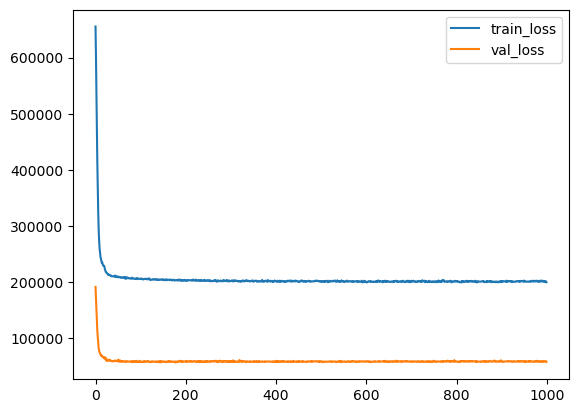

In [1638]:
plt.plot(train_loss_hk1, label = 'train_loss')
plt.plot(val_loss_hk1, label = 'val_loss')
plt.legend()
plt.show()

In [1768]:
y_label_plt = []
y_pred_plt = []
test_r2_hk1, test_mae_hk1 = test(test_loader_hk1, model_hk1, isEDR=isEDR)
y_label_hk1 = y_label_plt
y_pred_hk1 = y_pred_plt

y_label :  1393.0333251953125 y_pred :  692.4808959960938
y_label :  1355.5555419921875 y_pred :  943.5186767578125
y_label :  1758.755615234375 y_pred :  1406.409912109375
y_label :  2251.755615234375 y_pred :  1304.4317626953125
y_label :  2202.522216796875 y_pred :  2017.7626953125
y_label :  1494.5888671875 y_pred :  2223.13623046875
y_label :  1038.177734375 y_pred :  869.1895141601562
y_label :  489.1555480957031 y_pred :  620.4987182617188
y_label :  307.5888977050781 y_pred :  298.3639831542969
y_label :  279.3888854980469 y_pred :  257.1502685546875
y_label :  1166.844482421875 y_pred :  285.3641052246094
y_label :  741.9055786132812 y_pred :  1297.4071044921875
y_label :  662.1166381835938 y_pred :  772.01171875
y_label :  1486.611083984375 y_pred :  667.4678955078125
y_label :  1089.4888916015625 y_pred :  1492.4442138671875
y_label :  651.7666625976562 y_pred :  975.5072021484375
y_label :  320.98333740234375 y_pred :  815.6998291015625
y_label :  1276.2667236328125 y_pred 

xlim is (-228.106396484375, 4790.234326171875)
ylim is (-219.30194436311723, 4639.490429270268)


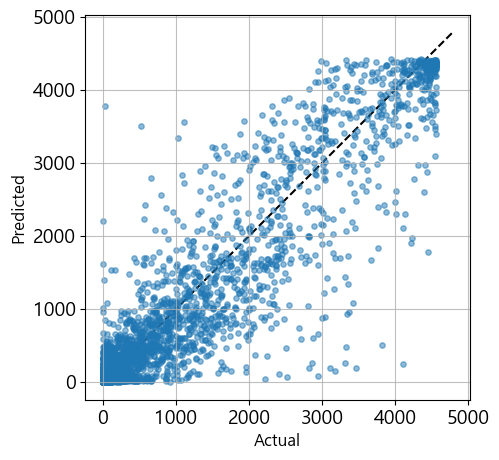

In [1734]:
plot_scatter(y_label_hk1,y_pred_hk1)

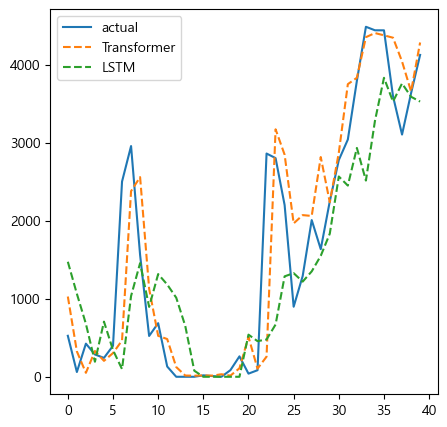

In [1779]:
#지민형 Transformer(E-D)
_start =20
_end = 60
#plt.title('')
plt.plot(y_label_hk1[_start:_end],label = 'actual')
plt.plot(y_pred_hk1[_start:_end],'--',label = 'Transformer')
plt.plot(prediction_hk1[_start:_end], '--',label = 'LSTM')

plt.legend()

In [1649]:
#hk2
lr = 0.001
criterion = nn.L1Loss()
optimizer = optim.AdamW(model_hk2.parameters(), lr=lr)
train_loss_hk2, val_loss_hk2= trainer(train_loader_hk2, test_loader_hk2, model_hk2, criterion, optimizer, target=target, n_epoch=n_epoch, PATH=PATH, isEDR=isEDR)


Epoch 0/1000
TRAIN
R2 score: -0.6252201714365406
MAE Loss:  3460.5724524799652
Validation
R2 score: -0.22082631864839097
MAE Loss:  913.4096668393677
Epoch 1/1000
TRAIN
R2 score: -0.5103079496991165
MAE Loss:  3282.125183490455
Validation
R2 score: 0.060770406405070365
MAE Loss:  803.2148593901844
Epoch 2/1000
TRAIN
R2 score: -0.37198825032640004
MAE Loss:  3074.2120788969905
Validation
R2 score: 0.3300679295374602
MAE Loss:  674.4247989181064
Epoch 3/1000
TRAIN
R2 score: -0.22686555443360112
MAE Loss:  2869.0273728318944
Validation
R2 score: 0.5360794538458226
MAE Loss:  571.589491776804
Epoch 4/1000
TRAIN
R2 score: -0.08778598271600035
MAE Loss:  2677.869313557682
Validation
R2 score: 0.6864367109982942
MAE Loss:  488.6557564037059
Epoch 5/1000
TRAIN
R2 score: 0.039497477413370286
MAE Loss:  2502.534023178975
Validation
R2 score: 0.772275192332482
MAE Loss:  405.5871085435178
Epoch 6/1000
TRAIN
R2 score: 0.15600523932645016
MAE Loss:  2334.69146546115
Validation
R2 score: 0.810845668

R2 score: 0.8089780645880762
MAE Loss:  376.8058382225144
Epoch 56/1000
TRAIN
R2 score: 0.8339272090673537
MAE Loss:  1116.0234970293368
Validation
R2 score: 0.8067469146961186
MAE Loss:  385.1827985800097
Epoch 57/1000
TRAIN
R2 score: 0.8336000159353731
MAE Loss:  1119.290764696634
Validation
R2 score: 0.81705687809229
MAE Loss:  371.2646038055856
Epoch 58/1000
TRAIN
R2 score: 0.8331107435349095
MAE Loss:  1116.688648297825
Validation
R2 score: 0.8070710217384338
MAE Loss:  400.7043078032013
Epoch 59/1000
TRAIN
R2 score: 0.833438457611469
MAE Loss:  1119.5606281379912
Validation
R2 score: 0.8288624928832591
MAE Loss:  365.21875362413937
Epoch 60/1000
TRAIN
R2 score: 0.8327585577458398
MAE Loss:  1123.067430409939
Validation
R2 score: 0.8299989842170079
MAE Loss:  353.19831717709616
Epoch 61/1000
TRAIN
R2 score: 0.8348098941133446
MAE Loss:  1117.3222239899555
Validation
R2 score: 0.8232298210593816
MAE Loss:  378.7356288415763
Epoch 62/1000
TRAIN
R2 score: 0.8340439016514942
MAE Loss:

R2 score: 0.8378161778247054
MAE Loss:  1097.9865989248087
Validation
R2 score: 0.8353735769522781
MAE Loss:  347.1225669277489
Epoch 112/1000
TRAIN
R2 score: 0.8376202994435892
MAE Loss:  1101.3909495803646
Validation
R2 score: 0.8099463459036155
MAE Loss:  369.2452460541808
Epoch 113/1000
TRAIN
R2 score: 0.8367317597091066
MAE Loss:  1103.5882460248622
Validation
R2 score: 0.818212995887027
MAE Loss:  362.9489438355456
Epoch 114/1000
TRAIN
R2 score: 0.8363231247762968
MAE Loss:  1103.6245264681113
Validation
R2 score: 0.8157074370283774
MAE Loss:  373.27122004511483
Epoch 115/1000
TRAIN
R2 score: 0.8365833020979316
MAE Loss:  1099.3371511889468
Validation
R2 score: 0.8226885121509899
MAE Loss:  355.5147164754403
Epoch 116/1000
TRAIN
R2 score: 0.8376313546342542
MAE Loss:  1101.1402974364828
Validation
R2 score: 0.8125028290314789
MAE Loss:  361.19787386473456
Epoch 117/1000
TRAIN
R2 score: 0.8361855483483334
MAE Loss:  1100.5748636189755
Validation
R2 score: 0.8105001717011102
MAE Lo

R2 score: 0.8179075957557689
MAE Loss:  371.7000821958182
Epoch 167/1000
TRAIN
R2 score: 0.839807958899282
MAE Loss:  1090.046391616089
Validation
R2 score: 0.8254743744380176
MAE Loss:  357.7737799244857
Epoch 168/1000
TRAIN
R2 score: 0.8391338971206229
MAE Loss:  1088.8648572888455
Validation
R2 score: 0.8219846528110581
MAE Loss:  362.0441362843123
Epoch 169/1000
TRAIN
R2 score: 0.8399732627457689
MAE Loss:  1087.4823090446464
Validation
R2 score: 0.8241004448266473
MAE Loss:  379.6423487391688
Epoch 170/1000
TRAIN
R2 score: 0.8383624687836416
MAE Loss:  1092.0618054688948
Validation
R2 score: 0.8272320825995639
MAE Loss:  361.7973259696939
Epoch 171/1000
TRAIN
R2 score: 0.83970630487993
MAE Loss:  1085.655197539999
Validation
R2 score: 0.8207777552779352
MAE Loss:  370.65192521657417
Epoch 172/1000
TRAIN
R2 score: 0.8407845805570475
MAE Loss:  1085.883411133189
Validation
R2 score: 0.8048576026964348
MAE Loss:  385.5186110458024
Epoch 173/1000
TRAIN
R2 score: 0.8395181705766505
MAE

R2 score: 0.8406542969358616
MAE Loss:  1084.219844645866
Validation
R2 score: 0.7925758776025966
MAE Loss:  399.5243058963892
Epoch 223/1000
TRAIN
R2 score: 0.8393630051271441
MAE Loss:  1087.737352383606
Validation
R2 score: 0.8379936889783771
MAE Loss:  355.6323931872204
Epoch 224/1000
TRAIN
R2 score: 0.8388932389690331
MAE Loss:  1089.2932194735472
Validation
R2 score: 0.8185492015133145
MAE Loss:  364.50488647676735
Epoch 225/1000
TRAIN
R2 score: 0.8400572691403602
MAE Loss:  1087.5180410519376
Validation
R2 score: 0.8243252903609897
MAE Loss:  377.46709783484266
Epoch 226/1000
TRAIN
R2 score: 0.8418354161783247
MAE Loss:  1082.374546396171
Validation
R2 score: 0.8059455843811815
MAE Loss:  373.13635228916155
Epoch 227/1000
TRAIN
R2 score: 0.8404038036011597
MAE Loss:  1084.9621893143023
Validation
R2 score: 0.8175854933007954
MAE Loss:  372.8339673913156
Epoch 228/1000
TRAIN
R2 score: 0.8401261010936593
MAE Loss:  1086.879569408872
Validation
R2 score: 0.814384623286348
MAE Loss:

R2 score: 0.8151228976105074
MAE Loss:  394.0160955792732
Epoch 278/1000
TRAIN
R2 score: 0.8403261023578852
MAE Loss:  1083.4559117901479
Validation
R2 score: 0.7939354450522123
MAE Loss:  375.1300256035696
Epoch 279/1000
TRAIN
R2 score: 0.8409387371941377
MAE Loss:  1080.9585340175915
Validation
R2 score: 0.8250005506592288
MAE Loss:  371.7461206622537
Epoch 280/1000
TRAIN
R2 score: 0.8410014632805172
MAE Loss:  1086.3843494625992
Validation
R2 score: 0.8031471735525778
MAE Loss:  404.93134093876296
Epoch 281/1000
TRAIN
R2 score: 0.8407845486002088
MAE Loss:  1089.2809366266392
Validation
R2 score: 0.7895763934658966
MAE Loss:  393.1837265598256
Epoch 282/1000
TRAIN
R2 score: 0.8414722738807984
MAE Loss:  1081.686228575085
Validation
R2 score: 0.8022995558290831
MAE Loss:  381.713124306977
Epoch 283/1000
TRAIN
R2 score: 0.840516824046676
MAE Loss:  1087.1443474946802
Validation
R2 score: 0.8181117508826398
MAE Loss:  369.62633615837603
Epoch 284/1000
TRAIN
R2 score: 0.8422552571951956

R2 score: 0.8412519345430534
MAE Loss:  1083.98034319926
Validation
R2 score: 0.7983706998128245
MAE Loss:  383.38119490479795
Epoch 334/1000
TRAIN
R2 score: 0.8421216313007884
MAE Loss:  1075.443565002583
Validation
R2 score: 0.7760608252033591
MAE Loss:  399.138258259973
Epoch 335/1000
TRAIN
R2 score: 0.8419873644971959
MAE Loss:  1084.4411390887178
Validation
R2 score: 0.8030384201014357
MAE Loss:  380.99028417018474
Epoch 336/1000
TRAIN
R2 score: 0.8398969599764163
MAE Loss:  1085.8784658013935
Validation
R2 score: 0.7941558726837554
MAE Loss:  408.0463608765638
Epoch 337/1000
TRAIN
R2 score: 0.8414130998188974
MAE Loss:  1085.6452216241419
Validation
R2 score: 0.7859808213638171
MAE Loss:  387.8241509494268
Epoch 338/1000
TRAIN
R2 score: 0.8423397204762975
MAE Loss:  1080.7521918176656
Validation
R2 score: 0.7814334277192954
MAE Loss:  394.78255544776505
Epoch 339/1000
TRAIN
R2 score: 0.8422461676913644
MAE Loss:  1077.2885151578387
Validation
R2 score: 0.7837404846341918
MAE Loss

R2 score: 0.8087290504592933
MAE Loss:  374.8344831249261
Epoch 389/1000
TRAIN
R2 score: 0.8426306872956906
MAE Loss:  1078.244559744942
Validation
R2 score: 0.7895071058777487
MAE Loss:  413.09700433589046
Epoch 390/1000
TRAIN
R2 score: 0.8413322766423136
MAE Loss:  1079.971509761195
Validation
R2 score: 0.7978612817014362
MAE Loss:  383.6193477491991
Epoch 391/1000
TRAIN
R2 score: 0.8410107909379605
MAE Loss:  1086.089591202914
Validation
R2 score: 0.7982065894486203
MAE Loss:  384.6483445532838
Epoch 392/1000
TRAIN
R2 score: 0.8415895753419129
MAE Loss:  1080.9007716753224
Validation
R2 score: 0.7955669409473962
MAE Loss:  377.913415262834
Epoch 393/1000
TRAIN
R2 score: 0.8411384633440592
MAE Loss:  1080.5123106589706
Validation
R2 score: 0.8005199982978537
MAE Loss:  388.52863258429886
Epoch 394/1000
TRAIN
R2 score: 0.8420157966346361
MAE Loss:  1078.828741945133
Validation
R2 score: 0.774044552367674
MAE Loss:  394.0227076262159
Epoch 395/1000
TRAIN
R2 score: 0.8411403459119942
MA

R2 score: 0.8403684254288175
MAE Loss:  1084.154047821066
Validation
R2 score: 0.7946151892819705
MAE Loss:  386.2040065955044
Epoch 445/1000
TRAIN
R2 score: 0.8437333607584263
MAE Loss:  1074.5404980789428
Validation
R2 score: 0.7442849985122586
MAE Loss:  418.51019086321486
Epoch 446/1000
TRAIN
R2 score: 0.8433812413195558
MAE Loss:  1077.2367446747905
Validation
R2 score: 0.7505960759283786
MAE Loss:  428.4560682890209
Epoch 447/1000
TRAIN
R2 score: 0.8425326976339444
MAE Loss:  1073.310565657748
Validation
R2 score: 0.7355863751127955
MAE Loss:  419.6650257766426
Epoch 448/1000
TRAIN
R2 score: 0.842070987408389
MAE Loss:  1080.9028749110892
Validation
R2 score: 0.8071924343816095
MAE Loss:  392.3317621151546
Epoch 449/1000
TRAIN
R2 score: 0.8422572296857718
MAE Loss:  1076.940398524763
Validation
R2 score: 0.789554147968387
MAE Loss:  389.58483095210875
Epoch 450/1000
TRAIN
R2 score: 0.8425337788337527
MAE Loss:  1081.1699352146782
Validation
R2 score: 0.8018503853267488
MAE Loss: 

R2 score: 0.7645273625392732
MAE Loss:  416.1442350219403
Epoch 500/1000
TRAIN
R2 score: 0.8422364453434362
MAE Loss:  1077.2665735522394
Validation
R2 score: 0.7926877963873233
MAE Loss:  397.1624929056392
Epoch 501/1000
TRAIN
R2 score: 0.8427787981962874
MAE Loss:  1077.7180574314661
Validation
R2 score: 0.7392520081427503
MAE Loss:  414.60157845123655
Epoch 502/1000
TRAIN
R2 score: 0.8407004103311133
MAE Loss:  1079.3736288380285
Validation
R2 score: 0.8244158805023687
MAE Loss:  358.236973424302
Epoch 503/1000
TRAIN
R2 score: 0.8421935855305521
MAE Loss:  1080.5809787221092
Validation
R2 score: 0.8083977009810961
MAE Loss:  375.86403035289396
Epoch 504/1000
TRAIN
R2 score: 0.8423359809171447
MAE Loss:  1073.8887698305232
Validation
R2 score: 0.7799265910312143
MAE Loss:  395.7524449111339
Epoch 505/1000
TRAIN
R2 score: 0.8434376496148644
MAE Loss:  1072.5065974424244
Validation
R2 score: 0.7667002025713109
MAE Loss:  392.1433671220111
Epoch 506/1000
TRAIN
R2 score: 0.84207065670473

R2 score: 0.8435704703523556
MAE Loss:  1072.8499843052944
Validation
R2 score: 0.7616958177579416
MAE Loss:  391.5420406780714
Epoch 556/1000
TRAIN
R2 score: 0.8426628097613704
MAE Loss:  1078.4497344538775
Validation
R2 score: 0.7789056100180556
MAE Loss:  384.6880385288145
Epoch 557/1000
TRAIN
R2 score: 0.8438444040731174
MAE Loss:  1070.923668858315
Validation
R2 score: 0.7478580308150855
MAE Loss:  417.07820195093774
Epoch 558/1000
TRAIN
R2 score: 0.8425199658826252
MAE Loss:  1076.014851056988
Validation
R2 score: 0.752699526064315
MAE Loss:  395.150578730865
Epoch 559/1000
TRAIN
R2 score: 0.8398151416095363
MAE Loss:  1082.622322055465
Validation
R2 score: 0.7278844545063783
MAE Loss:  427.08707315877416
Epoch 560/1000
TRAIN
R2 score: 0.8427393927489906
MAE Loss:  1078.2904582591784
Validation
R2 score: 0.7771860190726356
MAE Loss:  385.48894906504376
Epoch 561/1000
TRAIN
R2 score: 0.8426566612728366
MAE Loss:  1074.4380750038022
Validation
R2 score: 0.7186411000679717
MAE Loss:

R2 score: 0.7359053301796588
MAE Loss:  409.09734150966096
Epoch 611/1000
TRAIN
R2 score: 0.8428327124287258
MAE Loss:  1075.2772816857994
Validation
R2 score: 0.7462904833038615
MAE Loss:  402.8827521247908
Epoch 612/1000
TRAIN
R2 score: 0.8432305797339312
MAE Loss:  1069.4027664807152
Validation
R2 score: 0.7632339110772803
MAE Loss:  390.0343815327178
Epoch 613/1000
TRAIN
R2 score: 0.8434949030968882
MAE Loss:  1072.2774434002042
Validation
R2 score: 0.7485220956458873
MAE Loss:  411.23879796462245
Epoch 614/1000
TRAIN
R2 score: 0.8441304926811725
MAE Loss:  1071.3477677397805
Validation
R2 score: 0.7513999349865679
MAE Loss:  395.11421174240553
Epoch 615/1000
TRAIN
R2 score: 0.8437605190823543
MAE Loss:  1067.5981986533548
Validation
R2 score: 0.7586453172381251
MAE Loss:  396.0489333033844
Epoch 616/1000
TRAIN
R2 score: 0.8441128398382878
MAE Loss:  1070.3896358204818
Validation
R2 score: 0.7765168343392297
MAE Loss:  376.6377878734941
Epoch 617/1000
TRAIN
R2 score: 0.843115652570

R2 score: 0.8435204449103172
MAE Loss:  1070.5173735825208
Validation
R2 score: 0.811564904394949
MAE Loss:  382.5590365784996
Epoch 667/1000
TRAIN
R2 score: 0.842691905392583
MAE Loss:  1073.389466901697
Validation
R2 score: 0.7996972688217291
MAE Loss:  385.10590714793557
Epoch 668/1000
TRAIN
R2 score: 0.8441881525008554
MAE Loss:  1070.1317519474474
Validation
R2 score: 0.7577487335124837
MAE Loss:  401.99882686134816
Epoch 669/1000
TRAIN
R2 score: 0.8431308355277253
MAE Loss:  1077.6522455770457
Validation
R2 score: 0.8168933353761183
MAE Loss:  366.69476094788354
Epoch 670/1000
TRAIN
R2 score: 0.8442772571534773
MAE Loss:  1070.2777255261542
Validation
R2 score: 0.7662120798601211
MAE Loss:  407.24178337772565
Epoch 671/1000
TRAIN
R2 score: 0.8452836620000218
MAE Loss:  1069.6111824157638
Validation
R2 score: 0.7691669001271919
MAE Loss:  397.45906756520014
Epoch 672/1000
TRAIN
R2 score: 0.8431895993828563
MAE Loss:  1071.9940585482143
Validation
R2 score: 0.7915285817757095
MAE L

R2 score: 0.7658144787653642
MAE Loss:  408.19830587054645
Epoch 722/1000
TRAIN
R2 score: 0.8422654309416844
MAE Loss:  1070.9120197097561
Validation
R2 score: 0.742914060573745
MAE Loss:  416.7699989792479
Epoch 723/1000
TRAIN
R2 score: 0.8419212421768795
MAE Loss:  1075.8455265247592
Validation
R2 score: 0.7407189234890734
MAE Loss:  409.1724915687553
Epoch 724/1000
TRAIN
R2 score: 0.843393933771523
MAE Loss:  1069.2037299556735
Validation
R2 score: 0.8143345270356279
MAE Loss:  366.1494143524674
Epoch 725/1000
TRAIN
R2 score: 0.8421018455019167
MAE Loss:  1075.571466107055
Validation
R2 score: 0.775187247737219
MAE Loss:  393.09588122729747
Epoch 726/1000
TRAIN
R2 score: 0.8429697697795996
MAE Loss:  1073.4298386764353
Validation
R2 score: 0.7923222189411925
MAE Loss:  387.71782936197087
Epoch 727/1000
TRAIN
R2 score: 0.8439696920736077
MAE Loss:  1068.6109603728978
Validation
R2 score: 0.7272570693761908
MAE Loss:  417.45153069201467
Epoch 728/1000
TRAIN
R2 score: 0.841337092722938

R2 score: 0.7807515140415312
MAE Loss:  385.7102055355188
Epoch 777/1000
TRAIN
R2 score: 0.8434223479355274
MAE Loss:  1069.8667212939363
Validation
R2 score: 0.8057850268107734
MAE Loss:  365.08761544326853
Epoch 778/1000
TRAIN
R2 score: 0.8441021841311502
MAE Loss:  1068.1970799824674
Validation
R2 score: 0.7618272309880232
MAE Loss:  407.56643916597005
Epoch 779/1000
TRAIN
R2 score: 0.8445622993691303
MAE Loss:  1063.7453591505114
Validation
R2 score: 0.7517742476820797
MAE Loss:  429.34091913278206
Epoch 780/1000
TRAIN
R2 score: 0.8425848692087785
MAE Loss:  1075.098556036032
Validation
R2 score: 0.8044220445987667
MAE Loss:  373.845081125405
Epoch 781/1000
TRAIN
R2 score: 0.8429550786474411
MAE Loss:  1076.249775821528
Validation
R2 score: 0.7774215478728772
MAE Loss:  396.4444517061012
Epoch 782/1000
TRAIN
R2 score: 0.8439108859089034
MAE Loss:  1067.241154123469
Validation
R2 score: 0.762122964381121
MAE Loss:  404.6848800704396
Epoch 783/1000
TRAIN
R2 score: 0.8417661413146683


R2 score: 0.7584746416355652
MAE Loss:  400.91802735198127
Epoch 832/1000
TRAIN
R2 score: 0.8423476971432208
MAE Loss:  1077.0381100506365
Validation
R2 score: 0.7382919740081698
MAE Loss:  398.72899907510117
Epoch 833/1000
TRAIN
R2 score: 0.8435590036340328
MAE Loss:  1067.1938739851726
Validation
R2 score: 0.77649454701946
MAE Loss:  385.13151486154624
Epoch 834/1000
TRAIN
R2 score: 0.8426529453444399
MAE Loss:  1073.1868352400268
Validation
R2 score: 0.7962583903307346
MAE Loss:  382.7268118125513
Epoch 835/1000
TRAIN
R2 score: 0.8431780805711082
MAE Loss:  1072.7362846304711
Validation
R2 score: 0.7670959118235305
MAE Loss:  392.011140760587
Epoch 836/1000
TRAIN
R2 score: 0.842240740913352
MAE Loss:  1073.6705422436348
Validation
R2 score: 0.7913080716230023
MAE Loss:  380.61560201309175
Epoch 837/1000
TRAIN
R2 score: 0.843122233617971
MAE Loss:  1070.875293942802
Validation
R2 score: 0.7950234248082432
MAE Loss:  378.974876509771
Epoch 838/1000
TRAIN
R2 score: 0.8416543472125851
M

R2 score: 0.8434197685171545
MAE Loss:  1072.8774659136654
Validation
R2 score: 0.7670098766631864
MAE Loss:  394.21208288346173
Epoch 888/1000
TRAIN
R2 score: 0.8409895260105604
MAE Loss:  1076.704066262652
Validation
R2 score: 0.7113991921906273
MAE Loss:  432.195033850735
Epoch 889/1000
TRAIN
R2 score: 0.8448331787009379
MAE Loss:  1069.4599438489622
Validation
R2 score: 0.7892431308319374
MAE Loss:  391.61805591871274
Epoch 890/1000
TRAIN
R2 score: 0.8437679613141518
MAE Loss:  1073.535305778354
Validation
R2 score: 0.7737393447917023
MAE Loss:  398.00009146517147
Epoch 891/1000
TRAIN
R2 score: 0.8412535160484826
MAE Loss:  1080.4502921151131
Validation
R2 score: 0.7754730187951122
MAE Loss:  384.09633397240185
Epoch 892/1000
TRAIN
R2 score: 0.8444261390182822
MAE Loss:  1069.0715558946933
Validation
R2 score: 0.7521565311094034
MAE Loss:  405.96413177184877
Epoch 893/1000
TRAIN
R2 score: 0.842953568111916
MAE Loss:  1078.6263981312243
Validation
R2 score: 0.7880294891138654
MAE Lo

R2 score: 0.7470540590812889
MAE Loss:  414.23417952295375
Epoch 943/1000
TRAIN
R2 score: 0.843752483509097
MAE Loss:  1068.203875204166
Validation
R2 score: 0.7328237440345815
MAE Loss:  414.07449380828007
Epoch 944/1000
TRAIN
R2 score: 0.8405683448987581
MAE Loss:  1078.137892026591
Validation
R2 score: 0.7771275292341889
MAE Loss:  387.4552648635078
Epoch 945/1000
TRAIN
R2 score: 0.8430227190609327
MAE Loss:  1077.0456798879775
Validation
R2 score: 0.7785501304031434
MAE Loss:  398.9960136373436
Epoch 946/1000
TRAIN
R2 score: 0.8434937991008062
MAE Loss:  1072.744000300962
Validation
R2 score: 0.7069905768806087
MAE Loss:  465.661795001686
Epoch 947/1000
TRAIN
R2 score: 0.8442468066735903
MAE Loss:  1070.0970475849424
Validation
R2 score: 0.7172343074754739
MAE Loss:  423.3071225997785
Epoch 948/1000
TRAIN
R2 score: 0.844331367007613
MAE Loss:  1067.272393774577
Validation
R2 score: 0.7335200845041847
MAE Loss:  421.04670826531884
Epoch 949/1000
TRAIN
R2 score: 0.8445233444703484
MA

R2 score: 0.8424190941846517
MAE Loss:  1076.1709796059238
Validation
R2 score: 0.7880009316489196
MAE Loss:  378.569811682003
Epoch 999/1000
TRAIN
R2 score: 0.8430088668377527
MAE Loss:  1070.070084203816
Validation
R2 score: 0.7932840197979742
MAE Loss:  374.888137648179


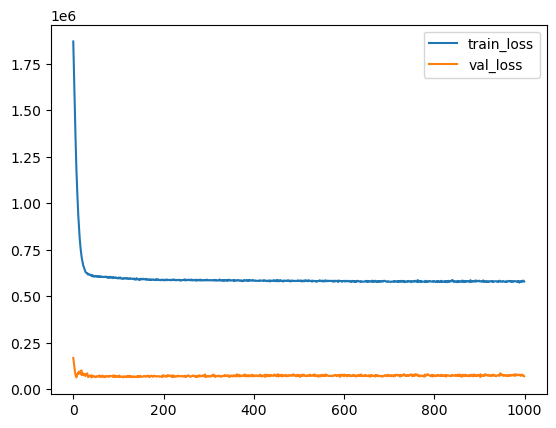

In [1650]:
plt.plot(train_loss_hk2, label = 'train_loss')
plt.plot(val_loss_hk2, label = 'val_loss')
plt.legend()
plt.show()

In [1770]:
y_label_plt = []
y_pred_plt = []
test_r2_hk2, test_mae_hk2 = test(test_loader_hk2, model_hk2, isEDR=isEDR)
y_label_hk2 = y_label_plt
y_pred_hk2 = y_pred_plt

y_label :  1393.0333251953125 y_pred :  907.6295166015625
y_label :  1355.5555419921875 y_pred :  1302.9857177734375
y_label :  1758.755615234375 y_pred :  1533.9820556640625
y_label :  2251.755615234375 y_pred :  1642.5494384765625
y_label :  2202.522216796875 y_pred :  1990.8555908203125
y_label :  1494.5888671875 y_pred :  2612.929443359375
y_label :  1038.177734375 y_pred :  979.0130615234375
y_label :  489.1555480957031 y_pred :  696.5997314453125
y_label :  307.5888977050781 y_pred :  206.85012817382812
y_label :  279.3888854980469 y_pred :  146.16485595703125
y_label :  1166.844482421875 y_pred :  176.16912841796875
y_label :  741.9055786132812 y_pred :  1458.02294921875
y_label :  662.1166381835938 y_pred :  762.7012329101562
y_label :  1486.611083984375 y_pred :  729.07470703125
y_label :  1089.4888916015625 y_pred :  1627.4129638671875
y_label :  651.7666625976562 y_pred :  1206.148681640625
y_label :  320.98333740234375 y_pred :  809.0810546875
y_label :  1276.2667236328125 

xlim is (-228.106396484375, 4790.234326171875)
ylim is (-391.20809745788574, 7835.36533164978)


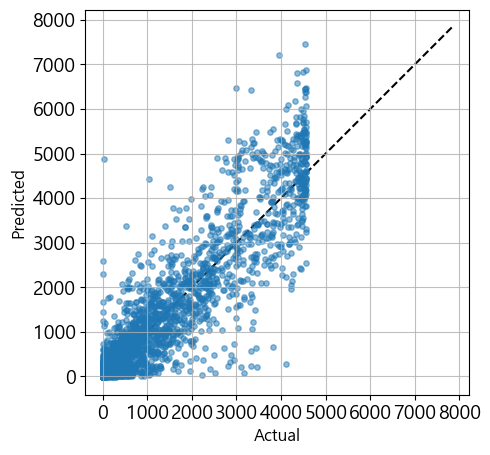

In [1736]:
plot_scatter(y_label_hk2,y_pred_hk2)

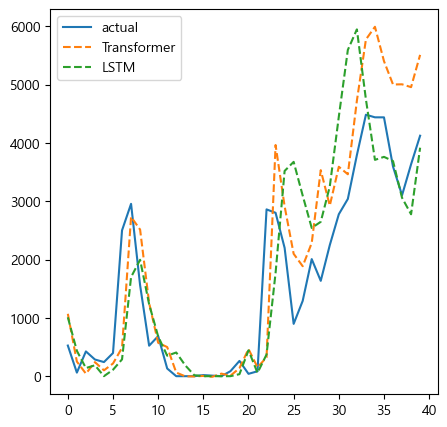

In [1781]:
#지민형 Transformer(E-D)
_start =20
_end = 60
#plt.title('hk2_transformer')

plt.plot(y_label_hk2[_start:_end],label = 'actual')
plt.plot(y_pred_hk2[_start:_end],'--',label = 'Transformer')
plt.plot(prediction_hk2[_start:_end], '--',label = 'LSTM')

plt.legend()

In [1667]:
#ss
lr = 0.001
criterion = nn.L1Loss()
optimizer = optim.AdamW(model_ss.parameters(), lr=lr)
train_loss_ss, val_loss_ss= trainer(train_loader_ss, test_loader_ss, model_ss, criterion, optimizer, target=target, n_epoch=n_epoch, PATH=PATH, isEDR=isEDR)


Epoch 0/1000
TRAIN
R2 score: -0.8466036420681586
MAE Loss:  4960.403901619223
Validation
R2 score: -0.8863453137720618
MAE Loss:  5348.9136819854675
Epoch 1/1000
TRAIN
R2 score: -0.7472094926906465
MAE Loss:  4743.40721998498
Validation
R2 score: -0.755341434814351
MAE Loss:  5098.530655951715
Epoch 2/1000
TRAIN
R2 score: -0.6021444009275363
MAE Loss:  4449.264873066892
Validation
R2 score: -0.6005355443580453
MAE Loss:  4759.054806097569
Epoch 3/1000
TRAIN
R2 score: -0.4470838869441218
MAE Loss:  4154.318537613843
Validation
R2 score: -0.4379943984069279
MAE Loss:  4437.943823027365
Epoch 4/1000
TRAIN
R2 score: -0.2928420374030445
MAE Loss:  3866.0835608828165
Validation
R2 score: -0.28571830094339457
MAE Loss:  4145.993024156222
Epoch 5/1000
TRAIN
R2 score: -0.1500205077760013
MAE Loss:  3610.6755425152896
Validation
R2 score: -0.14823455838168265
MAE Loss:  3874.5136691067605
Epoch 6/1000
TRAIN
R2 score: -0.020663794709602223
MAE Loss:  3377.8763141746167
Validation
R2 score: -0.017

R2 score: 0.7406019613461856
MAE Loss:  1903.2055133403462
Epoch 56/1000
TRAIN
R2 score: 0.7549723047813992
MAE Loss:  1773.8994746807402
Validation
R2 score: 0.7482696384108931
MAE Loss:  1901.4081919454243
Epoch 57/1000
TRAIN
R2 score: 0.7545978028317236
MAE Loss:  1780.0032199111643
Validation
R2 score: 0.7384232383397729
MAE Loss:  1938.7153638000525
Epoch 58/1000
TRAIN
R2 score: 0.7560493333235861
MAE Loss:  1774.075696682559
Validation
R2 score: 0.7202628432665699
MAE Loss:  1968.9738664975866
Epoch 59/1000
TRAIN
R2 score: 0.7553831969784628
MAE Loss:  1772.4068698564342
Validation
R2 score: 0.7509924646845374
MAE Loss:  1864.363922461689
Epoch 60/1000
TRAIN
R2 score: 0.7558295390536994
MAE Loss:  1773.6537747179625
Validation
R2 score: 0.7416591561936955
MAE Loss:  1906.5204950384334
Epoch 61/1000
TRAIN
R2 score: 0.7544997630106385
MAE Loss:  1777.19738587172
Validation
R2 score: 0.7453807327503135
MAE Loss:  1899.6922199371543
Epoch 62/1000
TRAIN
R2 score: 0.7560749137358915
MA

R2 score: 0.7625939309743061
MAE Loss:  1748.9208066804188
Validation
R2 score: 0.7411536599082001
MAE Loss:  1886.3456519639444
Epoch 112/1000
TRAIN
R2 score: 0.7607373502498731
MAE Loss:  1751.5722426915804
Validation
R2 score: 0.762850733895137
MAE Loss:  1816.9328327749777
Epoch 113/1000
TRAIN
R2 score: 0.7607291767731399
MAE Loss:  1761.0895544210866
Validation
R2 score: 0.7660716167467467
MAE Loss:  1809.2997556917446
Epoch 114/1000
TRAIN
R2 score: 0.7536738582995777
MAE Loss:  1781.3431876996535
Validation
R2 score: 0.7426271480936306
MAE Loss:  1877.968333583979
Epoch 115/1000
TRAIN
R2 score: 0.7594976761936997
MAE Loss:  1753.3449498905925
Validation
R2 score: 0.7459930440378397
MAE Loss:  1864.4391250232425
Epoch 116/1000
TRAIN
R2 score: 0.7615126382481856
MAE Loss:  1745.643666451654
Validation
R2 score: 0.7655691367313194
MAE Loss:  1810.9305948059255
Epoch 117/1000
TRAIN
R2 score: 0.7630110423012257
MAE Loss:  1743.9166117558707
Validation
R2 score: 0.7576456005524088
MAE 

R2 score: 0.7640008255405695
MAE Loss:  1746.3687891293564
Validation
R2 score: 0.7614478756151642
MAE Loss:  1823.4473328837032
Epoch 167/1000
TRAIN
R2 score: 0.7654913805115241
MAE Loss:  1735.8912869013445
Validation
R2 score: 0.7657089866353768
MAE Loss:  1809.9121297529778
Epoch 168/1000
TRAIN
R2 score: 0.765279332926929
MAE Loss:  1735.9255055284557
Validation
R2 score: 0.7680855503581199
MAE Loss:  1816.885264782283
Epoch 169/1000
TRAIN
R2 score: 0.7623788277900638
MAE Loss:  1745.9201717090718
Validation
R2 score: 0.7663418503697177
MAE Loss:  1812.9445832893086
Epoch 170/1000
TRAIN
R2 score: 0.7653456126731896
MAE Loss:  1738.3091262122205
Validation
R2 score: 0.7677703317113268
MAE Loss:  1808.199816631123
Epoch 171/1000
TRAIN
R2 score: 0.7664489688629142
MAE Loss:  1737.1819193634885
Validation
R2 score: 0.7586599672675637
MAE Loss:  1842.4560046294894
Epoch 172/1000
TRAIN
R2 score: 0.7660868453578797
MAE Loss:  1733.6558673704099
Validation
R2 score: 0.7704330620105184
MAE 

R2 score: 0.7683822181157693
MAE Loss:  1727.5536411268904
Validation
R2 score: 0.7642261778867485
MAE Loss:  1833.1861667067185
Epoch 222/1000
TRAIN
R2 score: 0.7689804612435485
MAE Loss:  1725.2136808616483
Validation
R2 score: 0.7668846996940142
MAE Loss:  1802.464257586845
Epoch 223/1000
TRAIN
R2 score: 0.7650968371237887
MAE Loss:  1736.2370968421028
Validation
R2 score: 0.7625294988096969
MAE Loss:  1833.0725485657674
Epoch 224/1000
TRAIN
R2 score: 0.768136048780508
MAE Loss:  1726.9704180821968
Validation
R2 score: 0.7701820681974182
MAE Loss:  1804.1596670382623
Epoch 225/1000
TRAIN
R2 score: 0.7675262472947769
MAE Loss:  1727.219570575316
Validation
R2 score: 0.7700153576117188
MAE Loss:  1799.7969058569054
Epoch 226/1000
TRAIN
R2 score: 0.7697751212400588
MAE Loss:  1722.6993149773336
Validation
R2 score: 0.7699667619759529
MAE Loss:  1803.0930043749486
Epoch 227/1000
TRAIN
R2 score: 0.7664011151006339
MAE Loss:  1738.3953034299195
Validation
R2 score: 0.7500818333309689
MAE 

R2 score: 0.7697589333721736
MAE Loss:  1722.6024330377306
Validation
R2 score: 0.7623606495147525
MAE Loss:  1819.9292821247702
Epoch 277/1000
TRAIN
R2 score: 0.7686298091919871
MAE Loss:  1727.8272328657815
Validation
R2 score: 0.7691475739749362
MAE Loss:  1809.133718608662
Epoch 278/1000
TRAIN
R2 score: 0.7673520134929095
MAE Loss:  1729.4379499250083
Validation
R2 score: 0.7512290528712069
MAE Loss:  1862.2354868922107
Epoch 279/1000
TRAIN
R2 score: 0.7673625202744334
MAE Loss:  1727.869977323297
Validation
R2 score: 0.7600922525392568
MAE Loss:  1831.6115370146802
Epoch 280/1000
TRAIN
R2 score: 0.7668220200352273
MAE Loss:  1729.0286944094073
Validation
R2 score: 0.7545572763334214
MAE Loss:  1862.6706382231553
Epoch 281/1000
TRAIN
R2 score: 0.7693332606367889
MAE Loss:  1724.5419812281104
Validation
R2 score: 0.7611178210805899
MAE Loss:  1838.7475280491306
Epoch 282/1000
TRAIN
R2 score: 0.7661315049082256
MAE Loss:  1733.52508453624
Validation
R2 score: 0.7514912058361836
MAE L

R2 score: 0.765788413427623
MAE Loss:  1729.1505718021658
Validation
R2 score: 0.7652971093621358
MAE Loss:  1811.6958257329252
Epoch 332/1000
TRAIN
R2 score: 0.766547816390402
MAE Loss:  1732.0974600286497
Validation
R2 score: 0.7626051964822796
MAE Loss:  1823.0852529797016
Epoch 333/1000
TRAIN
R2 score: 0.7674970387884629
MAE Loss:  1727.7768189865278
Validation
R2 score: 0.7664332597469948
MAE Loss:  1819.325940242652
Epoch 334/1000
TRAIN
R2 score: 0.7675389824117245
MAE Loss:  1731.6962911116075
Validation
R2 score: 0.7655854900264285
MAE Loss:  1815.157196629808
Epoch 335/1000
TRAIN
R2 score: 0.7668080578926649
MAE Loss:  1731.1290398042233
Validation
R2 score: 0.7649453074517479
MAE Loss:  1813.9187864351613
Epoch 336/1000
TRAIN
R2 score: 0.7679461730073969
MAE Loss:  1723.3945432572218
Validation
R2 score: 0.7545184187249458
MAE Loss:  1844.5046034406275
Epoch 337/1000
TRAIN
R2 score: 0.7696867908228326
MAE Loss:  1718.1672784682653
Validation
R2 score: 0.7671668761824852
MAE L

R2 score: 0.7688654843550785
MAE Loss:  1723.8698863680665
Validation
R2 score: 0.7679553149303869
MAE Loss:  1808.0569352422865
Epoch 387/1000
TRAIN
R2 score: 0.7633000581760457
MAE Loss:  1739.7255858500491
Validation
R2 score: 0.7582242280632472
MAE Loss:  1836.9570272493704
Epoch 388/1000
TRAIN
R2 score: 0.7704086184791573
MAE Loss:  1718.9995272791512
Validation
R2 score: 0.7645358168156539
MAE Loss:  1821.997160917019
Epoch 389/1000
TRAIN
R2 score: 0.7713132953956143
MAE Loss:  1715.7742718874792
Validation
R2 score: 0.7614625599997782
MAE Loss:  1822.1442603046032
Epoch 390/1000
TRAIN
R2 score: 0.7677819109458531
MAE Loss:  1731.4639440681697
Validation
R2 score: 0.7604568360680523
MAE Loss:  1839.0572338995971
Epoch 391/1000
TRAIN
R2 score: 0.7683359665535421
MAE Loss:  1724.461109721207
Validation
R2 score: 0.7667287093946178
MAE Loss:  1806.5159494717245
Epoch 392/1000
TRAIN
R2 score: 0.7699828335767182
MAE Loss:  1724.2451226979942
Validation
R2 score: 0.761420148427036
MAE 

R2 score: 0.7684073311843942
MAE Loss:  1724.146186852373
Validation
R2 score: 0.7656553007772943
MAE Loss:  1813.144210797252
Epoch 442/1000
TRAIN
R2 score: 0.7697084611884946
MAE Loss:  1723.8848853620625
Validation
R2 score: 0.7661380853106238
MAE Loss:  1819.7135615106306
Epoch 443/1000
TRAIN
R2 score: 0.7689815843793586
MAE Loss:  1721.931741512963
Validation
R2 score: 0.7614450596830996
MAE Loss:  1822.4958491069738
Epoch 444/1000
TRAIN
R2 score: 0.7685775364424962
MAE Loss:  1727.8955448893116
Validation
R2 score: 0.7640890156116872
MAE Loss:  1812.0170336178794
Epoch 445/1000
TRAIN
R2 score: 0.7683249753419018
MAE Loss:  1730.0976110067886
Validation
R2 score: 0.7552572522364964
MAE Loss:  1859.9597800110798
Epoch 446/1000
TRAIN
R2 score: 0.7703575297281963
MAE Loss:  1723.2671534587769
Validation
R2 score: 0.7654397872883544
MAE Loss:  1812.7908106679567
Epoch 447/1000
TRAIN
R2 score: 0.7605010017869881
MAE Loss:  1746.7332767220933
Validation
R2 score: 0.7682047099530591
MAE 

R2 score: 0.7681145798622395
MAE Loss:  1726.1845337027362
Validation
R2 score: 0.7576470400588242
MAE Loss:  1833.0486363125763
Epoch 497/1000
TRAIN
R2 score: 0.7709288154371335
MAE Loss:  1717.7452938096335
Validation
R2 score: 0.762538824343227
MAE Loss:  1815.442627421469
Epoch 498/1000
TRAIN
R2 score: 0.7686794996218457
MAE Loss:  1723.8135701518297
Validation
R2 score: 0.76832113815863
MAE Loss:  1802.7607356380486
Epoch 499/1000
TRAIN
R2 score: 0.7663028578935938
MAE Loss:  1737.2681993570297
Validation
R2 score: 0.761219548361984
MAE Loss:  1826.2320969841373
Epoch 500/1000
TRAIN
R2 score: 0.7693514618748383
MAE Loss:  1719.727615447083
Validation
R2 score: 0.7588878112621658
MAE Loss:  1837.679819506131
Epoch 501/1000
TRAIN
R2 score: 0.7670236635959421
MAE Loss:  1730.7462033041347
Validation
R2 score: 0.7658548910256043
MAE Loss:  1814.6936761529857
Epoch 502/1000
TRAIN
R2 score: 0.76956515170617
MAE Loss:  1721.824153289443
Validation
R2 score: 0.7607265738326825
MAE Loss:  

R2 score: 0.7704410346607988
MAE Loss:  1718.9658651310751
Validation
R2 score: 0.7661517644001001
MAE Loss:  1807.904776784148
Epoch 552/1000
TRAIN
R2 score: 0.7702723805712612
MAE Loss:  1717.5331552179905
Validation
R2 score: 0.7663273447492183
MAE Loss:  1815.9966918280954
Epoch 553/1000
TRAIN
R2 score: 0.7693159912171882
MAE Loss:  1725.6994089216787
Validation
R2 score: 0.7676823962361333
MAE Loss:  1811.6597115126424
Epoch 554/1000
TRAIN
R2 score: 0.7703896436097244
MAE Loss:  1718.321012217501
Validation
R2 score: 0.7506064367305206
MAE Loss:  1864.2178790506534
Epoch 555/1000
TRAIN
R2 score: 0.7698883841125361
MAE Loss:  1720.503155807558
Validation
R2 score: 0.7626202933733398
MAE Loss:  1819.3597778982235
Epoch 556/1000
TRAIN
R2 score: 0.771109659758993
MAE Loss:  1720.6539692518486
Validation
R2 score: 0.7606441320627664
MAE Loss:  1829.1488527904087
Epoch 557/1000
TRAIN
R2 score: 0.7691786376206542
MAE Loss:  1724.0567774464105
Validation
R2 score: 0.7701994067016251
MAE L

R2 score: 0.7684047914523314
MAE Loss:  1724.5234056675863
Validation
R2 score: 0.7464080539478468
MAE Loss:  1873.6694112819168
Epoch 607/1000
TRAIN
R2 score: 0.7675062924992522
MAE Loss:  1731.017569554746
Validation
R2 score: 0.7586229010732206
MAE Loss:  1830.7012468610915
Epoch 608/1000
TRAIN
R2 score: 0.7687528929717717
MAE Loss:  1720.370291192749
Validation
R2 score: 0.7525825424071051
MAE Loss:  1856.5093830383184
Epoch 609/1000
TRAIN
R2 score: 0.7680714241966379
MAE Loss:  1723.378088763786
Validation
R2 score: 0.7637195161812317
MAE Loss:  1819.483173732012
Epoch 610/1000
TRAIN
R2 score: 0.7690279311083834
MAE Loss:  1721.2864168105518
Validation
R2 score: 0.7595711221572815
MAE Loss:  1830.445114455372
Epoch 611/1000
TRAIN
R2 score: 0.7661243121594514
MAE Loss:  1736.6156521855
Validation
R2 score: 0.7569374160002151
MAE Loss:  1837.6800340733319
Epoch 612/1000
TRAIN
R2 score: 0.770712136645858
MAE Loss:  1718.8758770039065
Validation
R2 score: 0.7629770896303877
MAE Loss: 

R2 score: 0.7695305299069091
MAE Loss:  1718.8202101248635
Validation
R2 score: 0.7443231031651003
MAE Loss:  1883.237770865051
Epoch 662/1000
TRAIN
R2 score: 0.7716246060808348
MAE Loss:  1713.5978700684568
Validation
R2 score: 0.7488992037732294
MAE Loss:  1871.2822777272515
Epoch 663/1000
TRAIN
R2 score: 0.7695561107970132
MAE Loss:  1722.1061931701477
Validation
R2 score: 0.7608858560513125
MAE Loss:  1838.9141038423984
Epoch 664/1000
TRAIN
R2 score: 0.7603528787545275
MAE Loss:  1742.9740177078095
Validation
R2 score: 0.7679897975107496
MAE Loss:  1810.5012346059661
Epoch 665/1000
TRAIN
R2 score: 0.7689335015603245
MAE Loss:  1723.338871728508
Validation
R2 score: 0.7552856711732074
MAE Loss:  1852.5738412176283
Epoch 666/1000
TRAIN
R2 score: 0.7711533752568388
MAE Loss:  1717.9160721950468
Validation
R2 score: 0.7539518767019369
MAE Loss:  1856.1965182876024
Epoch 667/1000
TRAIN
R2 score: 0.7701708508422125
MAE Loss:  1714.390411424032
Validation
R2 score: 0.755393907735339
MAE L

R2 score: 0.7683498333968036
MAE Loss:  1718.7743887287525
Validation
R2 score: 0.7551943410396117
MAE Loss:  1843.5246580631529
Epoch 717/1000
TRAIN
R2 score: 0.7719411010986166
MAE Loss:  1711.2929085094077
Validation
R2 score: 0.7613134767918412
MAE Loss:  1825.3454008211174
Epoch 718/1000
TRAIN
R2 score: 0.7727919560319483
MAE Loss:  1706.6607513566332
Validation
R2 score: 0.7610994096900731
MAE Loss:  1826.7522106395954
Epoch 719/1000
TRAIN
R2 score: 0.771609750343729
MAE Loss:  1713.0152847526535
Validation
R2 score: 0.7510883537456128
MAE Loss:  1858.5791497390173
Epoch 720/1000
TRAIN
R2 score: 0.7663976115773464
MAE Loss:  1729.172830554991
Validation
R2 score: 0.7576341189143943
MAE Loss:  1841.5977438021048
Epoch 721/1000
TRAIN
R2 score: 0.7695930251565384
MAE Loss:  1716.1942803282504
Validation
R2 score: 0.7538624910782794
MAE Loss:  1854.0586782385285
Epoch 722/1000
TRAIN
R2 score: 0.7713701971616468
MAE Loss:  1713.9874564248937
Validation
R2 score: 0.7599678539313406
MAE

R2 score: 0.7690240275081976
MAE Loss:  1719.0333089475953
Validation
R2 score: 0.7642491259489762
MAE Loss:  1820.8942009414138
Epoch 772/1000
TRAIN
R2 score: 0.7704395030069713
MAE Loss:  1715.5518223343427
Validation
R2 score: 0.760727546160441
MAE Loss:  1828.3694721417678
Epoch 773/1000
TRAIN
R2 score: 0.7663914181516184
MAE Loss:  1726.3498666170424
Validation
R2 score: 0.7588957223770112
MAE Loss:  1829.5434360607985
Epoch 774/1000
TRAIN
R2 score: 0.7708919504579832
MAE Loss:  1714.4613383887688
Validation
R2 score: 0.7530677467298056
MAE Loss:  1871.4920503250717
Epoch 775/1000
TRAIN
R2 score: 0.7705602784062777
MAE Loss:  1716.920015563712
Validation
R2 score: 0.720225244629519
MAE Loss:  1968.7583515691279
Epoch 776/1000
TRAIN
R2 score: 0.7682324949096762
MAE Loss:  1721.7306548360862
Validation
R2 score: 0.7590767584641984
MAE Loss:  1835.1431047888111
Epoch 777/1000
TRAIN
R2 score: 0.7722551722485037
MAE Loss:  1709.5571542589723
Validation
R2 score: 0.7479452364142605
MAE 

R2 score: 0.7722523440873259
MAE Loss:  1707.1103743449216
Validation
R2 score: 0.7588076905409114
MAE Loss:  1835.470173319565
Epoch 827/1000
TRAIN
R2 score: 0.7707269901236351
MAE Loss:  1717.7754156069775
Validation
R2 score: 0.7622126196550647
MAE Loss:  1825.393416272959
Epoch 828/1000
TRAIN
R2 score: 0.7631269463170359
MAE Loss:  1739.8445088286167
Validation
R2 score: 0.7491206600998221
MAE Loss:  1861.983388265071
Epoch 829/1000
TRAIN
R2 score: 0.7687572609112706
MAE Loss:  1718.3655022598057
Validation
R2 score: 0.7660236481447696
MAE Loss:  1817.2730594699449
Epoch 830/1000
TRAIN
R2 score: 0.7700642414125024
MAE Loss:  1719.5112903711845
Validation
R2 score: 0.758241300902852
MAE Loss:  1838.991651609762
Epoch 831/1000
TRAIN
R2 score: 0.7720520680627967
MAE Loss:  1710.2698436888584
Validation
R2 score: 0.7459598663973401
MAE Loss:  1870.7662102446923
Epoch 832/1000
TRAIN
R2 score: 0.7693884075894128
MAE Loss:  1720.3471070732353
Validation
R2 score: 0.7482048910183294
MAE Lo

R2 score: 0.7720132389724482
MAE Loss:  1708.3312525766808
Validation
R2 score: 0.7403946251319531
MAE Loss:  1910.3478807838785
Epoch 882/1000
TRAIN
R2 score: 0.7702905308775224
MAE Loss:  1716.3406938513879
Validation
R2 score: 0.7547425208421864
MAE Loss:  1845.454720728452
Epoch 883/1000
TRAIN
R2 score: 0.7730026750195658
MAE Loss:  1703.2085177277477
Validation
R2 score: 0.7551644640615933
MAE Loss:  1854.078491245614
Epoch 884/1000
TRAIN
R2 score: 0.7715666961506158
MAE Loss:  1716.2409016675192
Validation
R2 score: 0.73248618721959
MAE Loss:  1915.314841229289
Epoch 885/1000
TRAIN
R2 score: 0.7701690857396775
MAE Loss:  1715.1305927664353
Validation
R2 score: 0.7342793888476131
MAE Loss:  1915.0285273138722
Epoch 886/1000
TRAIN
R2 score: 0.7661555574870212
MAE Loss:  1726.8267630974728
Validation
R2 score: 0.7546392488166433
MAE Loss:  1851.012009136321
Epoch 887/1000
TRAIN
R2 score: 0.7713471835136628
MAE Loss:  1709.7605049378046
Validation
R2 score: 0.7454870017084251
MAE Los

R2 score: 0.7700662777878067
MAE Loss:  1718.9130289994037
Validation
R2 score: 0.7489806225220909
MAE Loss:  1864.2185431756593
Epoch 937/1000
TRAIN
R2 score: 0.7699597455578293
MAE Loss:  1714.9941858209131
Validation
R2 score: 0.7605013925902383
MAE Loss:  1826.6064210168274
Epoch 938/1000
TRAIN
R2 score: 0.7709621247286441
MAE Loss:  1710.5359308676739
Validation
R2 score: 0.7583286238253697
MAE Loss:  1829.9969231917826
Epoch 939/1000
TRAIN
R2 score: 0.7701798074579228
MAE Loss:  1716.5493373345066
Validation
R2 score: 0.7478531130700933
MAE Loss:  1867.1450154321342
Epoch 940/1000
TRAIN
R2 score: 0.7701666054842166
MAE Loss:  1715.503859733078
Validation
R2 score: 0.7549037270890043
MAE Loss:  1855.0314459709223
Epoch 941/1000
TRAIN
R2 score: 0.7723230561656085
MAE Loss:  1707.9155725881717
Validation
R2 score: 0.7541639883713757
MAE Loss:  1849.2722718564257
Epoch 942/1000
TRAIN
R2 score: 0.7679276655142803
MAE Loss:  1718.883513255433
Validation
R2 score: 0.7551195757312065
MAE

R2 score: 0.7683982900242103
MAE Loss:  1723.6106140554227
Validation
R2 score: 0.7605000808594319
MAE Loss:  1831.1507436708423
Epoch 992/1000
TRAIN
R2 score: 0.7668484533256018
MAE Loss:  1725.289595298619
Validation
R2 score: 0.7506480500712103
MAE Loss:  1858.082559373376
Epoch 993/1000
TRAIN
R2 score: 0.7710494131969288
MAE Loss:  1718.7447309403617
Validation
R2 score: 0.7567515246841494
MAE Loss:  1847.127531592531
Epoch 994/1000
TRAIN
R2 score: 0.769518713714968
MAE Loss:  1714.329097353766
Validation
R2 score: 0.7518853582701438
MAE Loss:  1861.176460399276
Epoch 995/1000
TRAIN
R2 score: 0.7705225515463439
MAE Loss:  1709.5173839024058
Validation
R2 score: 0.7412750097721419
MAE Loss:  1896.1613079568824
Epoch 996/1000
TRAIN
R2 score: 0.7696087856381993
MAE Loss:  1715.3274854118852
Validation
R2 score: 0.7522384115405043
MAE Loss:  1855.4503365119858
Epoch 997/1000
TRAIN
R2 score: 0.7655089572759307
MAE Loss:  1736.5153562880168
Validation
R2 score: 0.7611659674247458
MAE Los

In [1796]:
torch.save(model_hk1,'./result/transformer_hk1.pth')

In [1795]:
torch.save(model_hk2,'./result/transformer_hk2.pth')

In [1794]:
torch.save(model_ss,'./result/transformer_ss.pth')

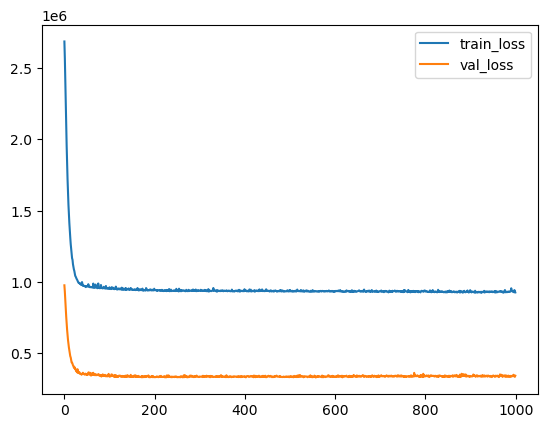

In [1668]:
plt.plot(train_loss_ss, label = 'train_loss')
plt.plot(val_loss_ss, label = 'val_loss')
plt.legend()
plt.show()

In [1730]:
def plot_scatter(y_test_, pred_, alpha=0.5, s=15):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['figure.figsize'] = (5,5)
    # mpl.rcParams['axes.unicode_minus'] = False

    fig, ax = plt.subplots()

    plt.scatter(y_test_, pred_, alpha=alpha, s=s)
    plt.xlabel('Actual', fontsize=12)
    plt.ylabel('Predicted', fontsize=12)
    plt.xticks(fontsize = 14, color = 'black')
    plt.yticks(fontsize = 14, color = 'black')

    print('xlim is', ax.get_xlim())
    print('ylim is', ax.get_ylim())

    lims = [0, np.max([ax.get_xlim(), ax.get_ylim()])]

    ax.plot(lims, lims, '--', alpha=1, zorder=0, color='black')
    ax.set_aspect('equal')

    plt.grid(alpha=0.8)
    plt.show()

In [1772]:
y_label_plt = []
y_pred_plt = []
test_r2_ss, test_mae_ss = test(test_loader_ss, model_ss, isEDR=isEDR)
y_label_ss = y_label_plt
y_pred_ss = y_pred_plt

y_label :  1610.261962890625 y_pred :  3950.834228515625
y_label :  8492.4189453125 y_pred :  1831.7540283203125
y_label :  13345.771484375 y_pred :  7958.7158203125
y_label :  11781.712890625 y_pred :  13292.365234375
y_label :  11699.203125 y_pred :  11844.529296875
y_label :  10247.5185546875 y_pred :  11998.4169921875
y_label :  8715.3447265625 y_pred :  10363.060546875
y_label :  6992.30908203125 y_pred :  8485.171875
y_label :  7158.04443359375 y_pred :  6201.8056640625
y_label :  9287.556640625 y_pred :  7387.974609375
y_label :  13307.5322265625 y_pred :  9333.6767578125
y_label :  15576.271484375 y_pred :  13272.7841796875
y_label :  5865.01904296875 y_pred :  15091.255859375
y_label :  5443.82177734375 y_pred :  5695.09375
y_label :  2711.306396484375 y_pred :  5491.52880859375
y_label :  5682.10498046875 y_pred :  2882.871337890625
y_label :  7950.78955078125 y_pred :  5817.30419921875
y_label :  7799.546875 y_pred :  6010.8212890625
y_label :  2257.879638671875 y_pred :  56

xlim is (-998.1119140625001, 20960.3501953125)
ylim is (-741.1183643341064, 16505.120126724243)


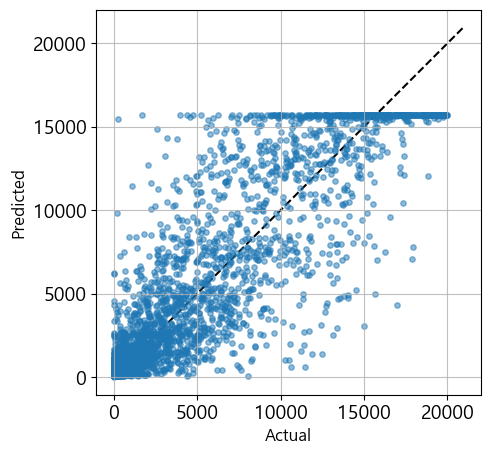

In [1732]:
plot_scatter(y_label_ss,y_pred_ss)

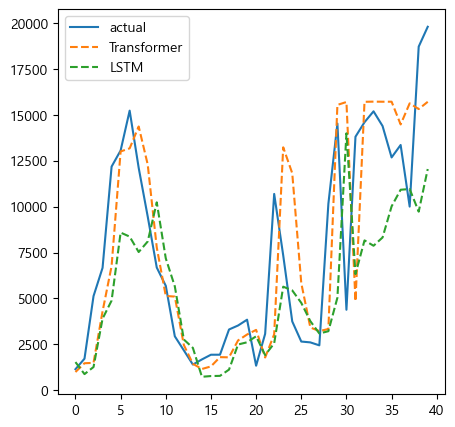

In [1782]:
#지민형 Transformer(E-D)
_start =20
_end = 60
#plt.title('ss_transformer')

plt.plot(y_label_ss[_start:_end],label = 'actual')
plt.plot(y_pred_ss[_start:_end],'--',label = 'Transformer')
plt.plot(prediction_ss[_start:_end], '--',label = 'LSTM')

plt.legend()

In [1670]:
def model_score(y_label, y_pred):
    print("R2 score:", sklearn.metrics.r2_score(y_label, y_pred))
    print("MAE Loss: ", sklearn.metrics.mean_absolute_error(y_label, y_pred))
    r2 = sklearn.metrics.r2_score(y_label, y_pred)
    mae = sklearn.metrics.mean_absolute_error(y_label, y_pred)
    return r2, mae

def test(data, model, isEDR=False):
    dev = 0
    model.eval()
    model = model.cuda(dev)

    y_label = []
    y_pred = []

    with torch.no_grad():
        if isEDR:
            for x, y, w in data:
                x = x.cuda(dev)
                y = y.cuda(dev)
                w = w.cuda(dev)

                _y = model(x, w)

                y_label.extend(y.reshape(-1).tolist())
                y_pred.extend(_y.reshape(-1).tolist())
        else:
            for x, y in data:
                x = x.cuda(dev)
                y = y.cuda(dev)

                _y = model(x)

                y_label.extend(y.reshape(-1).tolist())
                y_pred.extend(_y.reshape(-1).tolist())
    
    for _ in range(len(y_label)):
        y_label_plt.append(y_label[_])
        y_pred_plt.append(y_pred[_])
        print("y_label : ", y_label[_], "y_pred : ", y_pred[_])
    print("y_label-y_pred")
    return model_score(y_label, y_pred)

In [585]:
train_1_pr
train_1_pr_x = train_1_pr['windspeed']
train_1_pr_y = train_1_pr['hk1']

In [589]:
test_1_pr
test_1_pr_x = test_1_pr['windspeed']
test_1_pr_y = test_1_pr['hk1']

In [631]:
train_data = data_window(train_1_pr_x, train_1_pr_y, 14, 1)

C:\Users\iai\AppData\Local\Temp\ipykernel_12212\955761665.py:16: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [643]:
test_data = data_window(test_1_pr_x, test_1_pr_y, 14, 1)

C:\Users\iai\AppData\Local\Temp\ipykernel_12212\955761665.py:16: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [898]:
train = DataLoader(trainX, batch_size = 200, shuffle =False, num_workers = 0)

In [637]:
train = DataLoader(train_data , batch_size = 200, shuffle = False, num_workers = 0)

In [902]:
train_features, train_labels = next(iter(train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

ValueError: too many values to unpack (expected 2)

In [640]:
n_features = 2

In [1352]:
import torch
import torch.nn as nn
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        self.max_len = max_len
        position = torch.arange(max_len-1, -1, -1, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        #print("iiinput", x.shape)
        return x + self.pe[self.max_len-x.size(0):, :]

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, input_size, hidden_size, dropout, num_layers):
        super().__init__()
        self.src_mask = None
        self.d_model = d_model
        self.nhead = nhead
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.transformerencoderlayer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.nhead, dim_feedforward=self.dim_feedforward, dropout=self.dropout)
        self.norm = nn.LayerNorm(d_model)
        self.transformerencoder = nn.TransformerEncoder(encoder_layer=self.transformerencoderlayer, num_layers=self.num_layers, norm=self.norm)


    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        outputs = self.transformerencoder(src=src, mask=self.src_mask)

        return outputs

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

class TransformerDecoder(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, input_size, hidden_size, dropout, num_layers):
        super().__init__()
        self.memory_mask = None
        self.tgt_mask = None
        self.d_model = d_model
        self.nhead = nhead
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.transformerdecoderlayer = nn.TransformerDecoderLayer(d_model=self.d_model, nhead=self.nhead,
                                                                  dim_feedforward=self.dim_feedforward,
                                                                  dropout=self.dropout)
        self.norm = nn.LayerNorm(d_model)
        self.transformerdecoder = nn.TransformerDecoder(decoder_layer=self.transformerdecoderlayer,
                                                        num_layers=self.num_layers, norm=self.norm)

    def forward(self, tgt, memory):
        if self.tgt_mask is None or self.tgt_mask.size(0) != len(tgt):
            device = tgt.device
            mask = self._generate_square_subsequent_mask(len(tgt), len(tgt)).to(device)
            self.tgt_mask = mask

        if self.memory_mask is None or self.memory_mask.size(0) != len(memory):
            device = memory.device
            mask = self._generate_square_subsequent_mask(len(tgt), len(memory)).to(device)
            self.memory_mask = mask

        outputs = self.transformerdecoder(tgt=tgt, memory=memory, tgt_mask=self.tgt_mask, memory_mask=self.memory_mask)
        return outputs

    def _generate_square_subsequent_mask(self, tgt_sz, src_sz):
        mask = (torch.triu(torch.ones(src_sz, tgt_sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


class Transformer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, input_size, hidden_size, dropout, num_layers):
        super().__init__()
        self.src_mask = None
        self.tgt_mask = None
        self.memory_mask = None
        self.d_model = d_model
        self.nhead = nhead
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Linear(self.input_size, self.hidden_size)
        self.positional_encoding = PositionalEncoding(d_model=self.d_model)

        self.transformerEncoder = TransformerEncoder(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, input_size=input_size,
                    hidden_size=hidden_size, dropout=0.1, num_layers=num_layers)
        self.transformerDecoder = TransformerDecoder(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, input_size=input_size,
                        hidden_size=hidden_size, dropout=0.1, num_layers=num_layers)

        self.fc = nn.Linear(self.d_model, 1)

    def expandByNhead(self, vector, Nhead, dim=2):
        return torch.cat([vector for head in range(Nhead)], dim=dim)

In [1358]:
class SimpleTransformer(Transformer): #PVTRANS_ED
    def __init__(self, d_model, nhead, dim_feedforward, input_size, hidden_size, dropout, num_layers):
        super().__init__(d_model, nhead, dim_feedforward, input_size, hidden_size, dropout, num_layers)

    def forward(self, inputs):
        #print("input은 : ", inputs.shape)
        inputs = inputs.transpose(0, 1)
        #print("input은 : ", inputs.shape)
        src = inputs[:-1]
        tgt = inputs[-1:]
        #print("src = ", src.shape,src, "tgt = ", tgt.shape,tgt)
        
        src = self.embedding(src)
        src = self.expandByNhead(src, self.nhead)
        src = self.positional_encoding(src)
        memory = self.transformerEncoder(src)

        tgt = self.embedding(tgt)
        tgt = self.expandByNhead(tgt, self.nhead)
        tgt = self.positional_encoding(tgt)
        
        outputs = self.transformerDecoder(tgt, memory)
        outputs = outputs.transpose(0, 1)
        outputs = self.fc(outputs)

        return outputs

In [1161]:
class BaseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, dropout=self.dropout, num_layers=self.num_layers)

class Encoder(BaseLSTM):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__(input_size, hidden_size, num_layers, dropout)

    def forward(self, inputs):
        h0 = torch.zeros(self.num_layers, inputs.size(1), self.hidden_size).cuda(0)
        c0 = torch.zeros(self.num_layers, inputs.size(1), self.hidden_size).cuda(0)
        hidden = (h0, c0)

        return self.lstm(inputs, hidden)

class Decoder(BaseLSTM):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__(input_size, hidden_size, num_layers, dropout)

    def forward(self, inputs, hidden):
        return self.lstm(inputs, hidden)

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.num_layers = num_layers
        self.encoder = Encoder(input_size=self.input_size, hidden_size=self.hidden_size, dropout=self.dropout,
                               num_layers=self.num_layers)
        self.decoder = Decoder(input_size=self.input_size, hidden_size=self.hidden_size, dropout=self.dropout,
                               num_layers=self.num_layers)
        self.fc = nn.Linear(hidden_size, 1)



In [607]:
class windLSTM(SimpleLSTM):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__(input_size, hidden_size, num_layers, dropout)

    def forward(self, inputs):
        #print(inputs.shape)
        inputs = inputs.transpose(0, 1)
        #print(inputs.shape)
        #print("inputs[:-1]", inputs[:-1])
        #print("inputs[-1:]", inputs[-1:])
        enc_outputs, enc_hidden = self.encoder(inputs[:-1])
        #print("enc_outputs : ", enc_outputs)
        #print("enc_hidden : ", enc_hidden)
        dec_outputs, dec_hidden = self.decoder(inputs[-1:], enc_hidden)
        dec_outputs = dec_outputs.transpose(0, 1)
        #print("dec_outputs : ", dec_outputs)
        output = self.fc(dec_outputs)
        #print("output : ", output)
        return output

In [1011]:
def model_score(y_label, y_pred, target):
    try:
        print("R2 score:", sklearn.metrics.r2_score(y_label, y_pred))
        print("MAE Loss: ", sklearn.metrics.mean_absolute_error(y_label, y_pred))
    except Exception as e:
        print(e)


In [892]:
model = windLSTM(input_size=n_features, hidden_size=hidden_size, num_layers=num_layers , dropout=dropout).cuda(0)

In [968]:
# train 함수
def trainer(train_data, val_data, model, criterion, optimizer, n_epoch, target, PATH, isEDR=False):
    dev = 0
    model = model.cuda(dev)
    criterion = criterion.cuda(dev)

    phase = ["train", "val"]

    stop_loss = -1
    stop_step = 0
    max_stop = 10

    train_loss = []
    val_loss = []
    for epoch in range(n_epoch):
        print("Epoch {}/{}".format(epoch, n_epoch))
        for p in phase:
            if p == "train":
                print("TRAIN")
                model.train()
                data = train_data
            else:
                print("Validation")
                model.eval()
                data = val_data

            total_loss = 0
            y_label = []
            y_pred = []

            if isEDR:
                for x, y, w in data:
                    x = x.cuda(dev)
                    y = y.cuda(dev)
                    w = w.cuda(dev)

                    optimizer.zero_grad()

                    _y = model(x, w)

                    loss = criterion(y, _y)

                    if p == 'train':
                        loss.backward()
                        optimizer.step()

                    total_loss += loss.item()
                    y_label.extend(y.reshape(-1).tolist())
                    y_pred.extend(_y.reshape(-1).tolist())
            else:
                for x, y in data:
                    x = x.cuda(dev)
                    y = y.cuda(dev)

                    optimizer.zero_grad()

                    _y = model(x)

                    loss = criterion(_y, y)

                    if p == 'train':
                        loss.backward()
                        optimizer.step()

                    total_loss += loss.item()
                    y_label.extend(y.reshape(-1).tolist())
                    y_pred.extend(_y.reshape(-1).tolist())

            model_score(y_label, y_pred, target)

            if p == "val":
                val_loss.append(total_loss)
                #if total_loss < stop_loss or stop_loss == -1:
                #    torch.save(model.state_dict(), PATH)
                #    stop_loss = total_loss
                #    stop_step = 0
                #else:
                #    stop_step += 1
                #    if stop_step == max_stop:
                #        print("Early Stopping!")
                #        return train_loss, val_loss
            else:
                train_loss.append(total_loss)

    return train_loss, val_loss

In [610]:
model_name = "{}_L{}_S{}".format("LSTM", 1, 3)

In [611]:
k = 1 
name = "LSTM"
target = "hk1"

In [612]:
model_name = model_name + "_" + str(k)
PATH = "./result/{}/{}/{}.pth".format(target, name, model_name)
print(PATH)

./result/hk1/LSTM/LSTM_L1_S3_1.pth


In [613]:
hiddensize = 64

In [649]:
hidden_size=64
num_layers = 1
dropout = 0.1
n_epoch = 100
isEDR = False

In [650]:
model = windLSTM(input_size=n_features, hidden_size=hidden_size, num_layers=num_layers , dropout=dropout)

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1



In [657]:
lr = 0.01
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
train_loss, val_loss = trainer(train, test, model, criterion, optimizer, target=target, n_epoch=n_epoch, PATH=PATH, isEDR=isEDR)


Epoch 0/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.5218253038935483
MAE Loss:  1163.2718277878325
Validation
R2 score: -0.4255533037281445
MAE Loss:  1046.119736716005
Epoch 1/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.5067983115263348
MAE Loss:  1159.4056187462177
Validation
R2 score: -0.4118316182946
MAE Loss:  1043.3009594833197
Epoch 2/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.4926748250408446
MAE Loss:  1155.9341201889388
Validation
R2 score: -0.3990163821055772
MAE Loss:  1040.8408272703757
Epoch 3/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.4793476047003593
MAE Loss:  1152.792263713659
Validation
R2 score: -0.3869116128467478
MAE Loss:  1038.683217389872
Epoch 4/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.4668848454447363
MAE Loss:  1149.9800993999638
Validation
R2 score: -0.37575913887421186
MAE Loss:  1036.8334706332623
Epoch 5/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.45534880037030834
MAE Loss:  1147.4936840007572
Validation
R2 score: -0.36537458124960587
MAE Loss:  1035.2431507523352
Epoch 6/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.444612040035143
MAE Loss:  1145.275986031831
Validation
R2 score: -0.3557514622746252
MAE Loss:  1033.86792294166
Epoch 7/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.4346182421304594
MAE Loss:  1143.2982247715925
Validation
R2 score: -0.34671997310046887
MAE Loss:  1032.6334274570854
Epoch 8/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.42521575026855474
MAE Loss:  1141.5060912304236
Validation
R2 score: -0.33828207724254855
MAE Loss:  1031.517246407069
Epoch 9/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.41640254942942767
MAE Loss:  1139.876809506985
Validation
R2 score: -0.33035743541699336
MAE Loss:  1030.5586045409507
Epoch 10/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.4080993607332748
MAE Loss:  1138.4026552361267
Validation
R2 score: -0.32287909914616986
MAE Loss:  1029.7348785878783
Epoch 11/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.4002394468609085
MAE Loss:  1137.0437237603785
Validation
R2 score: -0.31580580556290383
MAE Loss:  1029.0020570124166
Epoch 12/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.392829319527515
MAE Loss:  1135.8109627988256
Validation
R2 score: -0.3091778360615576
MAE Loss:  1028.3368159101076
Epoch 13/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.38585049034430785
MAE Loss:  1134.6849287425066
Validation
R2 score: -0.3029269890657327
MAE Loss:  1027.7497626702286
Epoch 14/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.37923719848542614
MAE Loss:  1133.6552772682041
Validation
R2 score: -0.2970219728681329
MAE Loss:  1027.229141986796
Epoch 15/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3730126422491242
MAE Loss:  1132.7168144195673
Validation
R2 score: -0.29147516272731133
MAE Loss:  1026.7803750460748
Epoch 16/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3671175000991318
MAE Loss:  1131.8545687990302
Validation
R2 score: -0.28615181534639134
MAE Loss:  1026.3952388309804
Epoch 17/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3614337540352819
MAE Loss:  1131.04343665106
Validation
R2 score: -0.2811150321387872
MAE Loss:  1026.05855707383
Epoch 18/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.35610173993752103
MAE Loss:  1130.3055683795158
Validation
R2 score: -0.27636146303683184
MAE Loss:  1025.7703695650926
Epoch 19/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.35105180080172493
MAE Loss:  1129.6346244866263
Validation
R2 score: -0.2718846750769417
MAE Loss:  1025.5187941607567
Epoch 20/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3463085335604432
MAE Loss:  1129.017776499974
Validation
R2 score: -0.2676608878096036
MAE Loss:  1025.3007585409252
Epoch 21/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.34183229251076375
MAE Loss:  1128.4585130245796
Validation
R2 score: -0.2637073183501122
MAE Loss:  1025.1106825569864
Epoch 22/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.337626224997841
MAE Loss:  1127.9488454529956
Validation
R2 score: -0.2599900439615741
MAE Loss:  1024.9383027252536
Epoch 23/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.33363229685463525
MAE Loss:  1127.4820036269996
Validation
R2 score: -0.25642873159574675
MAE Loss:  1024.7850807074992
Epoch 24/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3298698536059679
MAE Loss:  1127.053595530256
Validation
R2 score: -0.2531357322562331
MAE Loss:  1024.6532963117313
Epoch 25/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3263270930875697
MAE Loss:  1126.6654568839745
Validation
R2 score: -0.2500189765321925
MAE Loss:  1024.5376967444467
Epoch 26/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3229971523591211
MAE Loss:  1126.3125420411668
Validation
R2 score: -0.24707278403164312
MAE Loss:  1024.4408482546237
Epoch 27/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3198316183793213
MAE Loss:  1125.9853213378162
Validation
R2 score: -0.2442522447114881
MAE Loss:  1024.3680516909744
Epoch 28/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3167844472681376
MAE Loss:  1125.6776197790184
Validation
R2 score: -0.24154818123896682
MAE Loss:  1024.3129688486667
Epoch 29/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3138727814701441
MAE Loss:  1125.3897621695794
Validation
R2 score: -0.23896388886177267
MAE Loss:  1024.2823961792772
Epoch 30/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3110864011095744
MAE Loss:  1125.1189859138524
Validation
R2 score: -0.2364921480974631
MAE Loss:  1024.2593547356919
Epoch 31/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3084182730184446
MAE Loss:  1124.8664228852479
Validation
R2 score: -0.23413916366237641
MAE Loss:  1024.2454628631888
Epoch 32/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.30587922926524214
MAE Loss:  1124.6328743677163
Validation
R2 score: -0.23188944317470273
MAE Loss:  1024.235100622687
Epoch 33/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3034298939208113
MAE Loss:  1124.4116197359015
Validation
R2 score: -0.229712789910115
MAE Loss:  1024.229789083371
Epoch 34/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.30106108120578745
MAE Loss:  1124.2000192051862
Validation
R2 score: -0.227606251980349
MAE Loss:  1024.2311314577487
Epoch 35/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.29877546231779406
MAE Loss:  1123.997722006838
Validation
R2 score: -0.22557489384465845
MAE Loss:  1024.2406980043838
Epoch 36/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2965636687370665
MAE Loss:  1123.8059789453475
Validation
R2 score: -0.22363343423954252
MAE Loss:  1024.2534550136393
Epoch 37/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.29447440872346786
MAE Loss:  1123.6293688461087
Validation
R2 score: -0.22182550852007932
MAE Loss:  1024.2697055819845
Epoch 38/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2925026866707885
MAE Loss:  1123.4694742635306
Validation
R2 score: -0.22009556524058294
MAE Loss:  1024.2905069660249
Epoch 39/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.29064976711023216
MAE Loss:  1123.3221039158316
Validation
R2 score: -0.21849591791477097
MAE Loss:  1024.310996274749
Epoch 40/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.28890820105003945
MAE Loss:  1123.188143715748
Validation
R2 score: -0.2169588193295866
MAE Loss:  1024.3329795795964
Epoch 41/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2872182028363226
MAE Loss:  1123.0592516804777
Validation
R2 score: -0.21545830385775444
MAE Loss:  1024.3562232625209
Epoch 42/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2855836164388743
MAE Loss:  1122.9358661845188
Validation
R2 score: -0.21402293712603182
MAE Loss:  1024.3831174190746
Epoch 43/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.28403618535536257
MAE Loss:  1122.8228228354772
Validation
R2 score: -0.2126987484569125
MAE Loss:  1024.4105691672762
Epoch 44/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2826161102360969
MAE Loss:  1122.7226625638727
Validation
R2 score: -0.2114642307999508
MAE Loss:  1024.4392154801815
Epoch 45/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.28127051265426184
MAE Loss:  1122.6297274699784
Validation
R2 score: -0.21028397453480085
MAE Loss:  1024.468749281224
Epoch 46/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.279980332275374
MAE Loss:  1122.5415655341149
Validation
R2 score: -0.20915953802844722
MAE Loss:  1024.4972847710042
Epoch 47/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.27875460583904244
MAE Loss:  1122.4598293543875
Validation
R2 score: -0.20811175528265036
MAE Loss:  1024.5258833227444
Epoch 48/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.27760039441448403
MAE Loss:  1122.3854954192243
Validation
R2 score: -0.20709337315160492
MAE Loss:  1024.5560647559423
Epoch 49/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2764828036220732
MAE Loss:  1122.3135605812092
Validation
R2 score: -0.2061156237865991
MAE Loss:  1024.5873554915534
Epoch 50/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.27540744032300135
MAE Loss:  1122.2461088995794
Validation
R2 score: -0.20516897102132892
MAE Loss:  1024.6188956710848
Epoch 51/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2743679370094767
MAE Loss:  1122.1815054829142
Validation
R2 score: -0.20425036160637822
MAE Loss:  1024.651628472529
Epoch 52/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.27336060080861535
MAE Loss:  1122.1189228117405
Validation
R2 score: -0.20338037176771406
MAE Loss:  1024.6834769783143
Epoch 53/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.272424288087056
MAE Loss:  1122.062276476158
Validation
R2 score: -0.20256821044274176
MAE Loss:  1024.7141851915376
Epoch 54/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2715233909638832
MAE Loss:  1122.0086373706597
Validation
R2 score: -0.20178296724584555
MAE Loss:  1024.7448962086814
Epoch 55/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.27066050199230896
MAE Loss:  1121.9580919158627
Validation
R2 score: -0.20102647648966743
MAE Loss:  1024.7751394226475
Epoch 56/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2698279373096706
MAE Loss:  1121.9094960941102
Validation
R2 score: -0.20029809652337782
MAE Loss:  1024.8049737682768
Epoch 57/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.26901736527347087
MAE Loss:  1121.8634095142595
Validation
R2 score: -0.1995813190983089
MAE Loss:  1024.8360384469756
Epoch 58/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.26823204662144806
MAE Loss:  1121.8185134903147
Validation
R2 score: -0.19889186181448415
MAE Loss:  1024.8664005387752
Epoch 59/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.26746595734436873
MAE Loss:  1121.7751500752277
Validation
R2 score: -0.19821572271551546
MAE Loss:  1024.8970789695306
Epoch 60/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2667253759130308
MAE Loss:  1121.7328665668986
Validation
R2 score: -0.197573098047364
MAE Loss:  1024.9268149679062
Epoch 61/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2660191059004211
MAE Loss:  1121.6936744553723
Validation
R2 score: -0.19695429761027938
MAE Loss:  1024.955545976017
Epoch 62/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.26532846921476705
MAE Loss:  1121.6561531847756
Validation
R2 score: -0.19633934382814977
MAE Loss:  1024.9850148983269
Epoch 63/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2646442696312503
MAE Loss:  1121.6186946565135
Validation
R2 score: -0.19573658741971478
MAE Loss:  1025.0143464285256
Epoch 64/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.26397875018027817
MAE Loss:  1121.5821960457617
Validation
R2 score: -0.19514756650346565
MAE Loss:  1025.0430619783176
Epoch 65/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2633396180224534
MAE Loss:  1121.5474063558947
Validation
R2 score: -0.19459128306445161
MAE Loss:  1025.0710806015595
Epoch 66/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2627241530383113
MAE Loss:  1121.514596675561
Validation
R2 score: -0.19404841109484328
MAE Loss:  1025.0992868774522
Epoch 67/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.26211896907125953
MAE Loss:  1121.4824271483405
Validation
R2 score: -0.19351712433258283
MAE Loss:  1025.1270254551825
Epoch 68/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.26152829884716167
MAE Loss:  1121.4511468318144
Validation
R2 score: -0.19300336963350473
MAE Loss:  1025.153883612336
Epoch 69/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2609587916683007
MAE Loss:  1121.4212107560527
Validation
R2 score: -0.19249887982546965
MAE Loss:  1025.1809553610312
Epoch 70/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2603969767859702
MAE Loss:  1121.391743808692
Validation
R2 score: -0.19200610603948065
MAE Loss:  1025.2078638102294
Epoch 71/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.25986074315491137
MAE Loss:  1121.3632358159082
Validation
R2 score: -0.19155506510700504
MAE Loss:  1025.2325204591211
Epoch 72/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2593656684927117
MAE Loss:  1121.3379728800953
Validation
R2 score: -0.19111847408579496
MAE Loss:  1025.2567369449814
Epoch 73/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2588811559841573
MAE Loss:  1121.3132972454086
Validation
R2 score: -0.1906936121123053
MAE Loss:  1025.2809525277064
Epoch 74/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.28910774049412713
MAE Loss:  1124.3833899461852
Validation
R2 score: -0.22814166848926387
MAE Loss:  1024.391674228733
Epoch 75/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.30889154740041125
MAE Loss:  1125.3504376247442
Validation
R2 score: -0.23986192383824134
MAE Loss:  1025.9340575264057
Epoch 76/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.31132082149617113
MAE Loss:  1125.6704391466726
Validation
R2 score: -0.2367069970577258
MAE Loss:  1025.3197508920816
Epoch 77/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3085814428191689
MAE Loss:  1125.0228658951733
Validation
R2 score: -0.23469528477341406
MAE Loss:  1024.921166223004
Epoch 78/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3061641094356986
MAE Loss:  1124.615523138723
Validation
R2 score: -0.23250406038830906
MAE Loss:  1024.91075743952
Epoch 79/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3037867133930523
MAE Loss:  1124.3001053908902
Validation
R2 score: -0.23025012639007247
MAE Loss:  1024.4105971749777
Epoch 80/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.30144192464340946
MAE Loss:  1123.8958982556294
Validation
R2 score: -0.2282120707101698
MAE Loss:  1024.4570309512872
Epoch 81/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2992361034848696
MAE Loss:  1123.6871216520046
Validation
R2 score: -0.22618087604494685
MAE Loss:  1024.1792421865277
Epoch 82/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.29780952108228953
MAE Loss:  1123.450950298188
Validation
R2 score: -0.22580105475082535
MAE Loss:  1024.2903519942768
Epoch 83/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2967078919151358
MAE Loss:  1123.3759705945643
Validation
R2 score: -0.22396804257069958
MAE Loss:  1024.1675717437747
Epoch 84/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2947158547285924
MAE Loss:  1123.1483936037798
Validation
R2 score: -0.2221449067378234
MAE Loss:  1024.1362205926002
Epoch 85/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2927783095640668
MAE Loss:  1122.9180437566413
Validation
R2 score: -0.2204986579471917
MAE Loss:  1024.088705752614
Epoch 86/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2909640417783732
MAE Loss:  1122.709169582831
Validation
R2 score: -0.21885192185594105
MAE Loss:  1023.863777990851
Epoch 87/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2893313766805383
MAE Loss:  1122.3202573272313
Validation
R2 score: -0.21836829316965867
MAE Loss:  1023.9465236840289
Epoch 88/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2878268401383588
MAE Loss:  1122.4849205953149
Validation
R2 score: -0.2159928499925261
MAE Loss:  1024.031135580667
Epoch 89/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2861130221346404
MAE Loss:  1122.2269173004888
Validation
R2 score: -0.2146254481032277
MAE Loss:  1023.8081076799136
Epoch 90/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2846976623760038
MAE Loss:  1121.8820810553016
Validation
R2 score: -0.2134539672584519
MAE Loss:  1023.5003576264816
Epoch 91/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.2849628098822572
MAE Loss:  1121.3669658879157
Validation
R2 score: -0.22254658105638314
MAE Loss:  1017.6011896526488
Epoch 92/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.29107473651483584
MAE Loss:  1099.8577146199232
Validation
R2 score: -0.2129922852741215
MAE Loss:  987.38067338218
Epoch 93/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.290659137831085
MAE Loss:  1095.1641685550674
Validation
R2 score: -0.2306251821340557
MAE Loss:  985.2251863583887
Epoch 94/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.30959444245167833
MAE Loss:  1096.447874280982
Validation
R2 score: -0.23700463044273357
MAE Loss:  980.6016805802958
Epoch 95/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3194031364943428
MAE Loss:  1098.5793572884402
Validation
R2 score: -0.2400507219805672
MAE Loss:  980.3136376808773
Epoch 96/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3177618490979919
MAE Loss:  1097.9019783169506
Validation
R2 score: -0.2371570733627324
MAE Loss:  978.3002843002815
Epoch 97/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.3207417361079825
MAE Loss:  1098.043420893168
Validation
R2 score: -0.24189535799374706
MAE Loss:  979.250078985556
Epoch 98/100
TRAIN


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules

R2 score: -0.32838348281147334
MAE Loss:  1101.1759555798594
Validation
R2 score: -0.2516089211718062
MAE Loss:  982.1909349083732
Epoch 99/100
TRAIN
R2 score: -0.341173210853585
MAE Loss:  1105.9926960541281
Validation
R2 score: -0.26238164136489295
MAE Loss:  985.9370594594938


C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([52, 1, 1])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\iai\anaconda3\envs\d_pytorch\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning:

Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [1374]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [75]:
#피쳐 추가
x_data["n_winddirection"] = np.abs(x_data["windspeed"])
x_data["n_winddirection"] = -np.sin(x_data["n_winddirection"])

x_data["s_winddirection"] = np.abs(x_data["windspeed"])
x_data["s_winddirection"] = -np.cos(x_data["s_winddirection"])

x_data["windrelationship"] = x_data["windspeed"] ** 3

x_data["tgt_season"] = (x_data.tgt_M%12 + 3)//3